In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
pd.options.display.max_rows = 100
from rich import print
import warnings
import datetime
from astropy.time import Time
import os
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import time
import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [3]:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

In [4]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

In [5]:
Simbad.add_votable_fields("otype","parallax")

In [6]:
tbl = pd.read_csv('gfcat_visit_table_positions.csv',index_col=0)

In [8]:
# Crossmatch to SIMBAD
for i in tqdm.tqdm(np.arange(len(tbl[:]))):
    ra,dec=tbl.iloc[i][['ra','dec']].values
    r = Simbad.query_region(coord.SkyCoord(ra,dec,
                            unit=(u.deg, u.deg)),#, frame='icrs'),
                            radius=35/60/60*u.deg)
    try:
        c = coord.SkyCoord(r['RA'],r['DEC'],unit=(u.hourangle, u.deg))
        d = angularSeparation(ra,dec,c.ra.deg,c.dec.deg)
        tbl.loc[i,'simbad_n_match'] = sum(d<17.5/60/60)
        # preserve the order of otype when unique-ifying them
        otype,ix=np.unique(np.array(r['OTYPE'],dtype='str'),return_index=True)
        tbl.loc[i,'simbad_otype'] = ', '.join(np.array(r['OTYPE'],dtype='str')[ix].tolist())
        tbl.loc[i,'simbad_main_id'] = r['MAIN_ID'][0]
        par,par_err = r['PLX_VALUE'][0],r['PLX_ERROR'][0]
        tbl.loc[i,'simbad_distance'] = 1000/r['PLX_VALUE'][0]
        tbl.loc[i,'simbad_distance_err_2']=(1000/par)-(1000/(par+par_err)) # upper error
        tbl.loc[i,'simbad_distance_err_1']=(1000/par)-(1000/(par-par_err)) # lower error (will be negative)
        tbl.loc[i,'simbad_parallax'] = r['PLX_VALUE'][0]
        tbl.loc[i,'simbad_parallax_err'] = r['PLX_ERROR'][0]
        c = coord.SkyCoord(f"{r['RA'][0]} {r['DEC'][0]}", unit=(u.hourangle, u.deg))
        tbl.loc[i,'simbad_match_offset'] = angularSeparation(ra,dec,c.ra.deg,c.dec.deg)[0]*60*60
    except TypeError:
        continue

tbl

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2065/2065 [00:21<00:00, 97.84it/s]


,eclipse,obj_id,ra,dec,morphology,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_distance_err_2,simbad_distance_err_1,simbad_parallax,simbad_parallax_err,simbad_match_offset
0,927,3.715901e+09,249.909813,41.112522,U,1.0,RRLyrae,V* AF Her,3149.606299,141.182712,-155.086363,0.3175,0.0149,2.223921
1,1413,1.953301e+09,311.565113,-4.930670,F,0.0,Low-Mass*,2MASS J20461427-0456025,817.862108,65.982408,-78.677248,1.2227,0.1073,23.589757
2,1420,1.468701e+09,315.935391,-7.379244,F,1.0,Low-Mass*,2MASS J21034437-0722434,484.871994,67.544557,-93.630837,2.0624,0.3338,0.720324
3,1422,1.479501e+09,343.352654,-39.793072,F,0.0,Galaxy,LEDA 2794348,NaN,NaN,NaN,NaN,NaN,31.206439
4,1534,1.091702e+09,259.445075,59.689607,F,1.0,Star,2MASS J17174656+5941240,129.152245,2.026059,-2.091685,7.7428,0.1234,2.397012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,46807,NaN,183.176317,-26.926904,U,1.0,HighPM*,2MASS J12124204-2655328,43.672699,0.052388,-0.052514,22.8976,0.0275,5.210580
2061,46818,NaN,184.069175,-30.364380,U,1.0,Star,UCAC2 19153424,1367.240908,29.269274,-30.578495,0.7314,0.0160,8.818930
2062,46828,NaN,183.706376,-32.431746,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2063,46828,NaN,183.710681,-32.431776,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
fn = '/Users/cm/github/gphoton_working/gPhoton/aspect/aspect.parquet'
for i in tqdm.tqdm(np.arange(len(tbl))[:]):
    eclipse = int(tbl.iloc[i]['eclipse'])
    aspect = pq.read_table(fn,filters=[('eclipse','=',eclipse)]).to_pandas()
    obstart = aspect.loc[aspect['flags']%2==0]['time'].min()
    #obsend = aspect.loc[aspect['flags']%2==0]['time'].max()
    #obsdur = obsend-obstart
    GPSSECS = 315532800 + 432000
    t = obstart + GPSSECS
    dt = datetime.datetime.fromtimestamp(t)
    tbl.loc[i,'obstart']=int(obstart)
    tbl.loc[i,'datetime_iso']=dt.isoformat().split('.')[0]
    tbl.loc[i,'datetime_decimal']=Time(dt,format='datetime').decimalyear
    ra,dec = tbl.iloc[i]['ra'],tbl.iloc[i]['dec']
    decimal_year = tbl.iloc[i]['datetime_decimal']
    #coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
    width = u.Quantity(0.05, u.deg)
    height = u.Quantity(0.05, u.deg)
    # the Gaia search API likes to timeout badly, randomly, often... so try to mitigate
    query_success=0
    while query_success==0:
        #print(ra,dec)
        try:
            r = Gaia.query_object_async(coordinate=coord.SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree),
                                                          frame='icrs'), width=width, height=height)
            query_success=1
        except TimeoutError:
            pass
    # compute the offset in years between the gaia epoch (2016) and the galex epoch
    year_offset = np.array(r['ref_epoch'])-decimal_year
    # the sky positions of gaia sources in degrees
    ra_gaia,dec_gaia = np.array(r['ra']),np.array(r['dec'])
    # the proper motions of gaia sources, converted from mas to deg per year
    ra_gaia_pm,dec_gaia_pm = np.array(r['pmra'])/60/60/1000,np.array(r['pmdec'])/60/60/1000
    # \"rewind\" the gaia sky positions by the proper motion rate by the difference in epochs
    ra_old = ra_gaia-ra_gaia_pm*year_offset
    dec_old = dec_gaia-dec_gaia_pm*year_offset

    # ignore nan values (usually because missing pm data)
    ix_finite = np.where(np.isfinite(ra_old) & np.isfinite(dec_old))
    d = angularSeparation(ra,dec,ra_old[ix_finite],dec_old[ix_finite])
    try:
        ix_match = np.argmin(d)
    except ValueError:
        print(f"No matching Gaia source for {i}")
        continue
    tbl.loc[i,'gaia_match_offset']=angularSeparation(ra,dec,r[ix]['ra'],r[ix]['dec'])*60*60
    tbl.loc[i,'gaia_n_match']=sum(d<17.5/60/60)
    if sum(d<17.5/60/60)==0:
        # no _good_ Gaia match for this source
        continue
    ix = ix_finite[0][ix_match]
    tbl.loc[i,'gaia_dr3_source_id']=r[ix]['source_id']
    #tbl.loc[i,'gaia_distance_uncorrected']=1000/r[ix]['parallax'][0]
    par,par_err = r[ix]['parallax'],r[ix]['parallax_error']
    tbl.loc[i,'gaia_distance']=1000/par
#    tbl.loc[i,'gaia_distance_err_1']=(1000/par)-(1000/(par+par_err))
#    tbl.loc[i,'gaia_distance_err_2']=(1000/(par-par_err))-(1000/par)
    tbl.loc[i,'gaia_distance_err_2']=(1000/par)-(1000/(par+par_err)) # upper error
    tbl.loc[i,'gaia_distance_err_1']=(1000/par)-(1000/(par-par_err)) # lower error (will be negative)
    tbl.loc[i,'gaia_parallax'] = par
    tbl.loc[i,'gaia_parallax_err'] = par_err
    tbl.loc[i,'gaia_parallax_over_err'] = r[ix]['parallax_over_error']
    tbl.loc[i,'pmra']=r[ix]['pmra']
    tbl.loc[i,'pmdec']=r[ix]['pmdec']
    tbl.loc[i,'gaia_ra']=r[ix]['ra']
    tbl.loc[i,'gaia_dec']=r[ix]['dec']
    #tbl.loc[i,'gaia_match_offset']=angularSeparation(ra,dec,r[ix]['ra'],r[ix]['dec'])*60*60
    #tbl.loc[i,'gaia_match_offset_uncorrected']=angularSeparation(ra,dec,
    #                                                             r[ix_goodsnr]['ra'][0],
    #                                                             r[ix_goodsnr]['dec'][0])*60*60
    #tbl.loc[i,'gaia_n_match']=sum(d<17.5/60/60)
    #tbl.loc[i,'high_pm']='Y' if ix!=0 else 'N' # the best match changed after 'rewinding'
    #time.sleep(1) # to prevent what I interpreted to be timeouts due to rate limiting

  0%|                                                                                                       | 1/2065 [00:02<1:19:30,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|                                                                                                       | 2/2065 [00:04<1:18:52,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▏                                                                                                      | 3/2065 [00:07<1:21:00,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▏                                                                                                      | 4/2065 [00:09<1:21:39,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▏                                                                                                      | 5/2065 [00:11<1:23:05,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▎                                                                                                      | 6/2065 [00:14<1:27:24,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▎                                                                                                      | 7/2065 [00:17<1:25:12,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▍                                                                                                      | 8/2065 [00:19<1:25:32,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▍                                                                                                      | 9/2065 [00:21<1:21:26,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  0%|▍                                                                                                     | 10/2065 [00:23<1:17:09,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▌                                                                                                     | 11/2065 [00:25<1:14:53,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▌                                                                                                     | 12/2065 [00:27<1:13:54,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▋                                                                                                     | 13/2065 [00:30<1:14:51,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▋                                                                                                     | 14/2065 [00:32<1:17:38,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▋                                                                                                     | 15/2065 [00:34<1:16:17,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▊                                                                                                     | 16/2065 [00:37<1:17:32,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▊                                                                                                     | 17/2065 [00:39<1:20:25,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▉                                                                                                     | 18/2065 [00:41<1:19:52,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▉                                                                                                     | 19/2065 [00:43<1:17:12,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|▉                                                                                                     | 20/2065 [00:46<1:17:39,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█                                                                                                     | 21/2065 [00:48<1:14:28,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█                                                                                                     | 22/2065 [00:50<1:12:32,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▏                                                                                                    | 23/2065 [00:52<1:14:17,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▏                                                                                                    | 24/2065 [00:54<1:15:56,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▏                                                                                                    | 25/2065 [00:57<1:16:03,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▎                                                                                                    | 26/2065 [00:59<1:16:11,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▎                                                                                                    | 27/2065 [01:01<1:18:20,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▍                                                                                                    | 28/2065 [01:04<1:19:49,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▍                                                                                                    | 29/2065 [01:06<1:18:58,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  1%|█▍                                                                                                    | 30/2065 [01:08<1:15:25,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▌                                                                                                    | 31/2065 [01:11<1:18:14,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▌                                                                                                    | 32/2065 [01:13<1:16:36,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▋                                                                                                    | 33/2065 [01:15<1:19:36,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▋                                                                                                    | 34/2065 [01:18<1:20:39,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▋                                                                                                    | 35/2065 [01:20<1:23:23,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▊                                                                                                    | 36/2065 [01:23<1:19:30,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▊                                                                                                    | 37/2065 [01:25<1:19:12,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▉                                                                                                    | 38/2065 [01:27<1:18:11,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▉                                                                                                    | 39/2065 [01:29<1:17:35,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|█▉                                                                                                    | 40/2065 [01:32<1:17:12,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██                                                                                                    | 41/2065 [01:34<1:16:37,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██                                                                                                    | 42/2065 [01:36<1:17:28,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██                                                                                                    | 43/2065 [01:38<1:17:15,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▏                                                                                                   | 44/2065 [01:41<1:15:30,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▏                                                                                                   | 45/2065 [01:43<1:16:04,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▎                                                                                                   | 46/2065 [01:45<1:17:05,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▎                                                                                                   | 47/2065 [01:48<1:19:14,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▎                                                                                                   | 48/2065 [01:50<1:21:09,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▍                                                                                                   | 49/2065 [01:53<1:22:36,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▍                                                                                                   | 50/2065 [01:55<1:22:33,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  2%|██▌                                                                                                   | 51/2065 [01:58<1:20:40,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|██▌                                                                                                   | 52/2065 [02:00<1:23:00,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|██▌                                                                                                   | 53/2065 [02:03<1:22:48,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|██▋                                                                                                   | 54/2065 [02:05<1:22:39,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|██▋                                                                                                   | 55/2065 [02:08<1:23:31,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|██▊                                                                                                   | 56/2065 [02:10<1:25:11,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|██▊                                                                                                   | 57/2065 [02:13<1:23:43,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|██▊                                                                                                   | 58/2065 [02:15<1:20:09,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|██▉                                                                                                   | 59/2065 [02:17<1:17:05,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|██▉                                                                                                   | 60/2065 [02:19<1:15:29,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███                                                                                                   | 61/2065 [02:22<1:17:33,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███                                                                                                   | 62/2065 [02:24<1:15:50,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███                                                                                                   | 63/2065 [02:26<1:18:37,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▏                                                                                                  | 64/2065 [02:29<1:20:37,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▏                                                                                                  | 65/2065 [02:31<1:20:29,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▎                                                                                                  | 66/2065 [02:34<1:18:56,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▎                                                                                                  | 67/2065 [02:36<1:17:33,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▎                                                                                                  | 68/2065 [02:38<1:18:20,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▍                                                                                                  | 69/2065 [02:41<1:20:24,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▍                                                                                                  | 70/2065 [02:43<1:18:58,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▌                                                                                                  | 71/2065 [02:45<1:16:54,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  3%|███▌                                                                                                  | 72/2065 [02:48<1:17:48,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|███▌                                                                                                  | 73/2065 [02:50<1:17:52,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|███▋                                                                                                  | 74/2065 [02:52<1:17:59,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|███▋                                                                                                  | 75/2065 [02:55<1:18:58,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|███▊                                                                                                  | 76/2065 [02:57<1:17:45,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|███▊                                                                                                  | 77/2065 [02:59<1:16:10,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|███▊                                                                                                  | 78/2065 [03:02<1:20:17,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|███▉                                                                                                  | 79/2065 [03:04<1:17:29,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|███▉                                                                                                  | 80/2065 [03:07<1:17:37,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████                                                                                                  | 81/2065 [03:09<1:18:47,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████                                                                                                  | 82/2065 [03:11<1:19:52,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████                                                                                                  | 83/2065 [03:14<1:20:00,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▏                                                                                                 | 84/2065 [03:16<1:21:05,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▏                                                                                                 | 85/2065 [03:19<1:24:39,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▏                                                                                                 | 86/2065 [03:22<1:23:57,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▎                                                                                                 | 87/2065 [03:24<1:22:04,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▎                                                                                                 | 88/2065 [03:26<1:18:50,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▍                                                                                                 | 89/2065 [03:29<1:17:31,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▍                                                                                                 | 90/2065 [03:31<1:15:18,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▍                                                                                                 | 91/2065 [03:33<1:17:49,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  4%|████▌                                                                                                 | 92/2065 [03:36<1:17:50,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▌                                                                                                 | 93/2065 [03:38<1:19:30,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▋                                                                                                 | 94/2065 [03:41<1:20:23,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▋                                                                                                 | 95/2065 [03:43<1:21:56,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▋                                                                                                 | 96/2065 [03:45<1:17:31,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▊                                                                                                 | 97/2065 [03:48<1:16:59,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▊                                                                                                 | 98/2065 [03:50<1:13:31,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▉                                                                                                 | 99/2065 [03:52<1:14:59,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▉                                                                                                | 100/2065 [03:54<1:14:40,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▉                                                                                                | 101/2065 [03:56<1:13:48,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|████▉                                                                                                | 102/2065 [03:59<1:15:44,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████                                                                                                | 103/2065 [04:01<1:15:32,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████                                                                                                | 104/2065 [04:03<1:13:51,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▏                                                                                               | 105/2065 [04:06<1:15:49,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▏                                                                                               | 106/2065 [04:08<1:12:34,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▏                                                                                               | 107/2065 [04:10<1:13:55,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▎                                                                                               | 108/2065 [04:12<1:13:06,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▎                                                                                               | 109/2065 [04:14<1:10:29,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▍                                                                                               | 110/2065 [04:17<1:12:39,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▍                                                                                               | 111/2065 [04:19<1:14:53,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▍                                                                                               | 112/2065 [04:21<1:12:54,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  5%|█████▌                                                                                               | 113/2065 [04:24<1:15:24,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|█████▌                                                                                               | 114/2065 [04:26<1:15:51,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|█████▌                                                                                               | 115/2065 [04:29<1:17:01,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|█████▋                                                                                               | 116/2065 [04:31<1:18:48,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|█████▋                                                                                               | 117/2065 [04:34<1:18:21,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|█████▊                                                                                               | 118/2065 [04:36<1:16:22,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|█████▊                                                                                               | 119/2065 [04:38<1:16:28,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|█████▊                                                                                               | 120/2065 [04:41<1:17:24,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|█████▉                                                                                               | 121/2065 [04:43<1:19:01,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|█████▉                                                                                               | 122/2065 [04:46<1:18:11,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████                                                                                               | 123/2065 [04:48<1:17:36,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████                                                                                               | 124/2065 [04:50<1:16:06,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████                                                                                               | 125/2065 [04:52<1:15:03,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████▏                                                                                              | 126/2065 [04:55<1:15:40,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████▏                                                                                              | 127/2065 [04:57<1:16:57,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████▎                                                                                              | 128/2065 [05:00<1:17:11,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████▎                                                                                              | 129/2065 [05:02<1:17:02,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████▎                                                                                              | 130/2065 [05:04<1:16:33,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████▍                                                                                              | 131/2065 [05:07<1:14:50,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████▍                                                                                              | 132/2065 [05:09<1:16:33,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████▌                                                                                              | 133/2065 [05:12<1:17:14,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  6%|██████▌                                                                                              | 134/2065 [05:21<2:29:46,  4.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|██████▌                                                                                              | 135/2065 [05:24<2:08:33,  4.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|██████▋                                                                                              | 136/2065 [05:26<1:54:39,  3.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|██████▋                                                                                              | 137/2065 [06:01<6:48:56, 12.73s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|██████▋                                                                                              | 138/2065 [06:03<5:10:25,  9.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|██████▊                                                                                              | 139/2065 [06:05<3:59:11,  7.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|██████▊                                                                                             | 140/2065 [08:17<23:51:49, 44.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|██████▊                                                                                             | 141/2065 [08:19<17:03:08, 31.91s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|██████▉                                                                                             | 142/2065 [08:21<12:16:38, 22.98s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|██████▉                                                                                              | 143/2065 [08:23<8:56:11, 16.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████                                                                                              | 144/2065 [08:26<6:37:54, 12.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████                                                                                              | 145/2065 [08:28<4:59:07,  9.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████▏                                                                                             | 146/2065 [08:30<3:53:09,  7.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████▏                                                                                             | 147/2065 [08:33<3:04:20,  5.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████▏                                                                                             | 148/2065 [08:35<2:33:26,  4.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████▎                                                                                             | 149/2065 [08:37<2:06:27,  3.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████▎                                                                                             | 150/2065 [08:39<1:48:57,  3.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████▍                                                                                             | 151/2065 [08:41<1:35:46,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████▍                                                                                             | 152/2065 [08:44<1:29:51,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████▍                                                                                             | 153/2065 [08:46<1:23:48,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  7%|███████▌                                                                                             | 154/2065 [08:48<1:19:11,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|███████▌                                                                                             | 155/2065 [08:51<1:20:26,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|███████▋                                                                                             | 156/2065 [08:53<1:15:11,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|███████▋                                                                                             | 157/2065 [08:55<1:14:06,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|███████▋                                                                                             | 158/2065 [08:57<1:14:19,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|███████▊                                                                                             | 159/2065 [09:00<1:13:37,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|███████▊                                                                                             | 160/2065 [09:02<1:14:47,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|███████▊                                                                                             | 161/2065 [09:04<1:13:44,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|███████▉                                                                                             | 162/2065 [09:07<1:15:24,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|███████▉                                                                                             | 163/2065 [09:09<1:14:45,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████                                                                                             | 164/2065 [09:11<1:13:44,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████                                                                                             | 165/2065 [09:13<1:12:27,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████                                                                                             | 166/2065 [09:16<1:16:29,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████▏                                                                                            | 167/2065 [09:18<1:15:15,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████▏                                                                                            | 168/2065 [09:21<1:12:40,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████▎                                                                                            | 169/2065 [09:23<1:10:08,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████▎                                                                                            | 170/2065 [09:25<1:10:26,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████▎                                                                                            | 171/2065 [09:27<1:09:39,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████▍                                                                                            | 172/2065 [09:29<1:10:12,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████▍                                                                                            | 173/2065 [09:33<1:21:56,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████▌                                                                                            | 174/2065 [09:35<1:18:46,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  8%|████████▌                                                                                            | 175/2065 [09:37<1:18:16,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████▌                                                                                            | 176/2065 [09:40<1:17:29,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████▋                                                                                            | 177/2065 [09:42<1:15:24,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████▋                                                                                            | 178/2065 [09:44<1:13:18,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████▊                                                                                            | 179/2065 [09:46<1:11:17,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████▊                                                                                            | 180/2065 [09:49<1:14:30,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████▊                                                                                            | 181/2065 [09:51<1:13:29,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████▉                                                                                            | 182/2065 [09:54<1:14:27,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████▉                                                                                            | 183/2065 [09:56<1:12:16,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|████████▉                                                                                            | 184/2065 [09:58<1:13:17,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████                                                                                            | 185/2065 [10:01<1:12:48,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████                                                                                            | 186/2065 [10:03<1:09:35,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▏                                                                                           | 187/2065 [10:05<1:12:23,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▏                                                                                           | 188/2065 [10:08<1:14:41,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▏                                                                                           | 189/2065 [10:10<1:16:14,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▎                                                                                           | 190/2065 [10:12<1:12:54,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▎                                                                                           | 191/2065 [10:14<1:10:18,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▍                                                                                           | 192/2065 [10:17<1:10:48,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▍                                                                                           | 193/2065 [10:19<1:12:30,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▍                                                                                           | 194/2065 [10:21<1:10:23,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▌                                                                                           | 195/2065 [10:23<1:09:15,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


  9%|█████████▌                                                                                           | 196/2065 [10:26<1:10:07,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████▋                                                                                           | 197/2065 [10:28<1:11:01,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████▋                                                                                           | 198/2065 [10:31<1:12:35,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████▋                                                                                           | 199/2065 [10:33<1:11:38,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████▊                                                                                           | 200/2065 [10:35<1:12:15,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████▊                                                                                           | 201/2065 [10:39<1:28:40,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████▉                                                                                           | 202/2065 [10:42<1:23:21,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████▉                                                                                           | 203/2065 [10:44<1:18:53,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|█████████▉                                                                                           | 204/2065 [10:46<1:16:18,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████                                                                                           | 205/2065 [10:48<1:15:12,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████                                                                                           | 206/2065 [10:50<1:11:19,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████                                                                                           | 207/2065 [10:53<1:12:09,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████▏                                                                                          | 208/2065 [10:56<1:18:06,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████▏                                                                                          | 209/2065 [10:58<1:17:26,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████▎                                                                                          | 210/2065 [11:01<1:16:18,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████▎                                                                                          | 211/2065 [11:03<1:15:50,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████▎                                                                                          | 212/2065 [11:05<1:14:37,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████▍                                                                                          | 213/2065 [11:07<1:12:20,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████▍                                                                                          | 214/2065 [11:10<1:13:21,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████▌                                                                                          | 215/2065 [11:12<1:09:46,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 10%|██████████▌                                                                                          | 216/2065 [11:14<1:11:31,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████▌                                                                                          | 217/2065 [11:17<1:11:24,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████▋                                                                                          | 218/2065 [11:19<1:13:24,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████▋                                                                                          | 219/2065 [11:21<1:11:36,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████▊                                                                                          | 220/2065 [11:23<1:08:14,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████▊                                                                                          | 221/2065 [11:26<1:07:45,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████▊                                                                                          | 222/2065 [11:29<1:17:01,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████▉                                                                                          | 223/2065 [11:31<1:16:22,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|██████████▉                                                                                          | 224/2065 [11:33<1:13:29,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████                                                                                          | 225/2065 [11:36<1:12:58,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████                                                                                          | 226/2065 [11:38<1:11:47,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████                                                                                          | 227/2065 [11:40<1:08:58,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▏                                                                                         | 228/2065 [11:42<1:07:00,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▏                                                                                         | 229/2065 [11:44<1:07:40,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▏                                                                                         | 230/2065 [11:46<1:06:49,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▎                                                                                         | 231/2065 [11:49<1:05:58,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▎                                                                                         | 232/2065 [11:52<1:13:26,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▍                                                                                         | 233/2065 [11:54<1:11:42,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▍                                                                                         | 234/2065 [11:56<1:10:46,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▍                                                                                         | 235/2065 [11:59<1:12:59,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▌                                                                                         | 236/2065 [12:01<1:11:39,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 11%|███████████▌                                                                                         | 237/2065 [12:03<1:10:36,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████▋                                                                                         | 238/2065 [12:06<1:12:19,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████▋                                                                                         | 239/2065 [12:08<1:11:44,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████▋                                                                                         | 240/2065 [12:10<1:10:15,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████▊                                                                                         | 241/2065 [12:12<1:10:18,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████▊                                                                                         | 242/2065 [12:15<1:09:35,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████▉                                                                                         | 243/2065 [12:17<1:07:11,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████▉                                                                                         | 244/2065 [12:19<1:06:45,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|███████████▉                                                                                         | 245/2065 [12:21<1:08:02,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████                                                                                         | 246/2065 [12:23<1:07:24,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████                                                                                         | 247/2065 [12:25<1:06:05,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▏                                                                                        | 248/2065 [12:27<1:04:22,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▏                                                                                        | 249/2065 [12:29<1:02:44,  2.07s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▏                                                                                        | 250/2065 [12:31<1:02:14,  2.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▎                                                                                        | 251/2065 [12:34<1:03:44,  2.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▎                                                                                        | 252/2065 [12:36<1:04:33,  2.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▎                                                                                        | 253/2065 [12:38<1:05:49,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▍                                                                                        | 254/2065 [12:40<1:04:12,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▍                                                                                        | 255/2065 [12:42<1:04:53,  2.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▌                                                                                        | 256/2065 [12:45<1:05:20,  2.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▌                                                                                        | 257/2065 [12:47<1:04:23,  2.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 12%|████████████▌                                                                                        | 258/2065 [12:49<1:06:10,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████▋                                                                                        | 259/2065 [12:51<1:06:45,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████▋                                                                                        | 260/2065 [12:54<1:09:15,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████▊                                                                                        | 261/2065 [12:56<1:08:51,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████▊                                                                                        | 262/2065 [12:58<1:06:59,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████▊                                                                                        | 263/2065 [13:00<1:07:13,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████▉                                                                                        | 264/2065 [13:02<1:05:26,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|████████████▉                                                                                        | 265/2065 [13:05<1:07:47,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████                                                                                        | 266/2065 [13:07<1:08:11,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████                                                                                        | 267/2065 [13:09<1:07:34,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████                                                                                        | 268/2065 [13:12<1:06:53,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▏                                                                                       | 269/2065 [13:14<1:06:53,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▏                                                                                       | 270/2065 [13:16<1:10:11,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▎                                                                                       | 271/2065 [13:19<1:12:24,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▎                                                                                       | 272/2065 [13:21<1:11:15,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▎                                                                                       | 273/2065 [13:23<1:09:39,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▍                                                                                       | 274/2065 [13:26<1:09:47,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▍                                                                                       | 275/2065 [13:28<1:11:51,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▍                                                                                       | 276/2065 [13:31<1:13:05,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▌                                                                                       | 277/2065 [13:33<1:10:21,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 13%|█████████████▌                                                                                       | 278/2065 [13:35<1:09:24,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████▋                                                                                       | 279/2065 [13:38<1:09:32,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████▋                                                                                       | 280/2065 [13:40<1:09:39,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████▋                                                                                       | 281/2065 [13:42<1:07:57,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████▊                                                                                       | 282/2065 [13:45<1:08:26,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████▊                                                                                       | 283/2065 [13:47<1:05:56,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████▉                                                                                       | 284/2065 [13:49<1:06:46,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████▉                                                                                       | 285/2065 [13:51<1:06:47,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|█████████████▉                                                                                       | 286/2065 [13:53<1:05:33,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████                                                                                       | 287/2065 [13:56<1:07:06,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████                                                                                       | 288/2065 [13:58<1:06:16,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▏                                                                                      | 289/2065 [14:00<1:07:38,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▏                                                                                      | 290/2065 [14:02<1:06:58,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▏                                                                                      | 291/2065 [14:05<1:08:55,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▎                                                                                      | 292/2065 [14:07<1:09:04,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▎                                                                                      | 293/2065 [14:10<1:10:09,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▍                                                                                      | 294/2065 [14:12<1:11:43,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▍                                                                                      | 295/2065 [14:14<1:07:39,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▍                                                                                      | 296/2065 [14:17<1:07:01,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▌                                                                                      | 297/2065 [14:19<1:08:35,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▌                                                                                      | 298/2065 [14:21<1:08:40,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 14%|██████████████▌                                                                                      | 299/2065 [14:24<1:08:03,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████▋                                                                                      | 300/2065 [14:26<1:06:04,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████▋                                                                                      | 301/2065 [14:28<1:07:30,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████▊                                                                                      | 302/2065 [14:30<1:07:12,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████▊                                                                                      | 303/2065 [14:33<1:06:04,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|██████████████▊                                                                                      | 304/2065 [14:35<1:05:01,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


No matching Gaia source for 304

 15%|██████████████▉                                                                                      | 306/2065 [14:39<1:03:14,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████                                                                                      | 307/2065 [14:41<1:04:05,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████                                                                                      | 308/2065 [14:43<1:04:37,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████                                                                                      | 309/2065 [14:45<1:03:28,  2.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▏                                                                                     | 310/2065 [14:47<1:01:49,  2.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▏                                                                                     | 311/2065 [14:50<1:02:24,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▎                                                                                     | 312/2065 [14:52<1:03:01,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▎                                                                                     | 313/2065 [14:54<1:02:26,  2.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▎                                                                                     | 314/2065 [14:56<1:03:23,  2.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▍                                                                                     | 315/2065 [14:58<1:01:52,  2.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▍                                                                                     | 316/2065 [15:00<1:02:06,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▌                                                                                     | 317/2065 [15:02<1:01:41,  2.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▌                                                                                     | 318/2065 [15:05<1:01:59,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▌                                                                                     | 319/2065 [15:07<1:02:35,  2.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 15%|███████████████▋                                                                                     | 320/2065 [15:09<1:01:40,  2.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|███████████████▋                                                                                     | 321/2065 [15:11<1:00:44,  2.09s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|███████████████▋                                                                                     | 322/2065 [15:13<1:03:16,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|███████████████▊                                                                                     | 323/2065 [15:16<1:05:33,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|███████████████▊                                                                                     | 324/2065 [15:18<1:05:35,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|███████████████▉                                                                                     | 325/2065 [15:20<1:05:30,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|███████████████▉                                                                                     | 326/2065 [15:23<1:06:37,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|███████████████▉                                                                                     | 327/2065 [15:25<1:07:38,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████                                                                                     | 328/2065 [15:27<1:05:21,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████                                                                                     | 329/2065 [15:29<1:02:46,  2.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▏                                                                                    | 330/2065 [15:31<1:04:48,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▏                                                                                    | 331/2065 [15:34<1:04:23,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▏                                                                                    | 332/2065 [15:36<1:06:50,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▎                                                                                    | 333/2065 [15:38<1:06:22,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▎                                                                                    | 334/2065 [15:41<1:07:36,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▍                                                                                    | 335/2065 [15:43<1:07:41,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▍                                                                                    | 336/2065 [15:46<1:07:40,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▍                                                                                    | 337/2065 [15:48<1:09:24,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▌                                                                                    | 338/2065 [15:50<1:07:15,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▌                                                                                    | 339/2065 [15:53<1:07:19,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 16%|████████████████▋                                                                                    | 340/2065 [15:55<1:05:44,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|████████████████▋                                                                                    | 341/2065 [15:57<1:08:00,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|████████████████▋                                                                                    | 342/2065 [16:00<1:10:28,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|████████████████▊                                                                                    | 343/2065 [16:03<1:10:30,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|████████████████▊                                                                                    | 344/2065 [16:05<1:08:25,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|████████████████▊                                                                                    | 345/2065 [16:07<1:06:39,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|████████████████▉                                                                                    | 346/2065 [16:09<1:06:23,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|████████████████▉                                                                                    | 347/2065 [16:11<1:05:26,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████                                                                                    | 348/2065 [16:14<1:09:16,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████                                                                                    | 349/2065 [16:16<1:07:01,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████                                                                                    | 350/2065 [16:19<1:07:10,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▏                                                                                   | 351/2065 [16:21<1:07:19,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▏                                                                                   | 352/2065 [16:23<1:06:45,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▎                                                                                   | 353/2065 [16:26<1:07:19,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▎                                                                                   | 354/2065 [16:28<1:07:09,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▎                                                                                   | 355/2065 [16:31<1:07:56,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▍                                                                                   | 356/2065 [16:33<1:10:18,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▍                                                                                   | 357/2065 [16:36<1:10:06,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▌                                                                                   | 358/2065 [16:38<1:07:41,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▌                                                                                   | 359/2065 [16:40<1:08:11,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▌                                                                                   | 360/2065 [16:43<1:07:20,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 17%|█████████████████▋                                                                                   | 361/2065 [16:45<1:07:48,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█████████████████▋                                                                                   | 362/2065 [16:48<1:08:56,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█████████████████▊                                                                                   | 363/2065 [16:50<1:07:25,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█████████████████▊                                                                                   | 364/2065 [16:52<1:08:01,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█████████████████▊                                                                                   | 365/2065 [16:57<1:23:37,  2.95s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█████████████████▉                                                                                   | 366/2065 [16:59<1:20:46,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█████████████████▉                                                                                   | 367/2065 [17:01<1:15:49,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|█████████████████▉                                                                                   | 368/2065 [17:04<1:12:59,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████                                                                                   | 369/2065 [17:06<1:09:41,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████                                                                                   | 370/2065 [17:08<1:06:14,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▏                                                                                  | 371/2065 [17:10<1:04:53,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▏                                                                                  | 372/2065 [17:13<1:05:17,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▏                                                                                  | 373/2065 [17:15<1:05:06,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▎                                                                                  | 374/2065 [17:17<1:05:00,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▎                                                                                  | 375/2065 [17:20<1:05:29,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▍                                                                                  | 376/2065 [17:22<1:05:57,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▍                                                                                  | 377/2065 [17:24<1:06:28,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▍                                                                                  | 378/2065 [17:27<1:08:46,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▌                                                                                  | 379/2065 [17:29<1:06:12,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▌                                                                                  | 380/2065 [17:31<1:05:27,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▋                                                                                  | 381/2065 [17:34<1:05:51,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 18%|██████████████████▋                                                                                  | 382/2065 [17:36<1:04:34,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|██████████████████▋                                                                                  | 383/2065 [17:38<1:03:26,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|██████████████████▊                                                                                  | 384/2065 [17:40<1:01:01,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|██████████████████▊                                                                                  | 385/2065 [17:42<1:01:33,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|██████████████████▉                                                                                  | 386/2065 [17:45<1:02:59,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|██████████████████▉                                                                                  | 387/2065 [17:47<1:03:37,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|██████████████████▉                                                                                  | 388/2065 [17:50<1:11:20,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████                                                                                  | 389/2065 [17:52<1:08:21,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████                                                                                  | 390/2065 [17:55<1:09:34,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████                                                                                  | 391/2065 [17:57<1:07:07,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▏                                                                                 | 392/2065 [18:00<1:06:34,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▏                                                                                 | 393/2065 [18:02<1:05:23,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▎                                                                                 | 394/2065 [18:04<1:05:45,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▎                                                                                 | 395/2065 [18:07<1:06:31,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▎                                                                                 | 396/2065 [18:09<1:07:07,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▍                                                                                 | 397/2065 [18:12<1:11:07,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▍                                                                                 | 398/2065 [18:15<1:10:49,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▌                                                                                 | 399/2065 [18:17<1:08:44,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▌                                                                                 | 400/2065 [18:19<1:07:56,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▌                                                                                 | 401/2065 [18:22<1:07:14,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 19%|███████████████████▋                                                                                 | 402/2065 [18:24<1:04:57,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|███████████████████▋                                                                                 | 403/2065 [18:26<1:04:08,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|███████████████████▊                                                                                 | 404/2065 [18:28<1:04:44,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|███████████████████▊                                                                                 | 405/2065 [18:31<1:03:10,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|███████████████████▊                                                                                 | 406/2065 [18:33<1:01:12,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|███████████████████▉                                                                                 | 407/2065 [18:35<1:01:36,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|███████████████████▉                                                                                 | 408/2065 [18:38<1:04:41,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████                                                                                 | 409/2065 [18:40<1:04:20,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████                                                                                 | 410/2065 [18:42<1:02:31,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████                                                                                 | 411/2065 [18:44<1:03:08,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▏                                                                                | 412/2065 [18:47<1:02:51,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▏                                                                                | 413/2065 [18:49<1:02:28,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▏                                                                                | 414/2065 [18:51<1:03:32,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▎                                                                                | 415/2065 [18:53<1:03:07,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▎                                                                                | 416/2065 [18:56<1:02:15,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▍                                                                                | 417/2065 [18:58<1:04:35,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▍                                                                                | 418/2065 [19:01<1:05:46,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▍                                                                                | 419/2065 [19:03<1:06:52,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▌                                                                                | 420/2065 [19:06<1:06:58,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▌                                                                                | 421/2065 [19:08<1:06:46,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▋                                                                                | 422/2065 [19:10<1:04:33,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 20%|████████████████████▋                                                                                | 423/2065 [19:13<1:03:39,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|████████████████████▋                                                                                | 424/2065 [19:15<1:07:13,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|████████████████████▊                                                                                | 425/2065 [19:18<1:07:37,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|████████████████████▊                                                                                | 426/2065 [19:20<1:05:30,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|████████████████████▉                                                                                | 427/2065 [19:22<1:05:21,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|████████████████████▉                                                                                | 428/2065 [19:25<1:04:43,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|████████████████████▉                                                                                | 429/2065 [19:27<1:04:35,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████                                                                                | 430/2065 [19:30<1:05:54,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████                                                                                | 431/2065 [19:32<1:05:50,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▏                                                                               | 432/2065 [19:35<1:06:29,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▏                                                                               | 433/2065 [19:37<1:06:09,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▏                                                                               | 434/2065 [19:39<1:05:55,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▎                                                                               | 435/2065 [19:42<1:04:37,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▎                                                                               | 436/2065 [19:44<1:03:40,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▎                                                                               | 437/2065 [19:46<1:03:30,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▍                                                                               | 438/2065 [19:49<1:02:45,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▍                                                                               | 439/2065 [19:51<1:03:59,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▌                                                                               | 440/2065 [19:53<1:04:57,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▌                                                                               | 441/2065 [19:56<1:05:50,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▌                                                                               | 442/2065 [19:59<1:06:49,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 21%|█████████████████████▋                                                                               | 443/2065 [20:01<1:06:48,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|█████████████████████▋                                                                               | 444/2065 [20:04<1:07:52,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|█████████████████████▊                                                                               | 445/2065 [20:06<1:07:41,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|█████████████████████▊                                                                               | 446/2065 [20:09<1:08:51,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|█████████████████████▊                                                                               | 447/2065 [20:11<1:06:47,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|█████████████████████▉                                                                               | 448/2065 [20:14<1:12:24,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|█████████████████████▉                                                                               | 449/2065 [20:17<1:09:57,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████                                                                               | 450/2065 [20:19<1:09:45,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████                                                                               | 451/2065 [20:21<1:05:49,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████                                                                               | 452/2065 [20:24<1:03:41,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▏                                                                              | 453/2065 [20:26<1:06:10,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▏                                                                              | 454/2065 [20:28<1:04:21,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▎                                                                              | 455/2065 [20:31<1:06:32,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▎                                                                              | 456/2065 [20:34<1:06:14,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▎                                                                              | 457/2065 [20:36<1:06:54,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▍                                                                              | 458/2065 [20:39<1:08:37,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▍                                                                              | 459/2065 [20:41<1:06:32,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▍                                                                              | 460/2065 [20:44<1:06:39,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▌                                                                              | 461/2065 [20:46<1:07:41,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▌                                                                              | 462/2065 [20:48<1:05:02,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▋                                                                              | 463/2065 [20:51<1:05:29,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 22%|██████████████████████▋                                                                              | 464/2065 [20:53<1:05:23,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████▋                                                                              | 465/2065 [20:56<1:06:31,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████▊                                                                              | 466/2065 [20:59<1:07:45,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████▊                                                                              | 467/2065 [21:01<1:07:22,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████▉                                                                              | 468/2065 [21:03<1:05:02,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████▉                                                                              | 469/2065 [21:06<1:05:52,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|██████████████████████▉                                                                              | 470/2065 [21:09<1:07:48,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████                                                                              | 471/2065 [21:11<1:05:13,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████                                                                              | 472/2065 [21:13<1:02:54,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▏                                                                             | 473/2065 [21:16<1:03:52,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▏                                                                             | 474/2065 [21:18<1:03:40,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▏                                                                             | 475/2065 [21:20<1:03:54,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▎                                                                             | 476/2065 [21:23<1:04:56,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▎                                                                             | 477/2065 [21:25<1:04:33,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▍                                                                             | 478/2065 [21:28<1:05:01,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▍                                                                             | 479/2065 [21:30<1:06:15,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▍                                                                             | 480/2065 [21:33<1:06:23,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▌                                                                             | 481/2065 [21:35<1:05:21,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▌                                                                             | 482/2065 [21:38<1:06:45,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▌                                                                             | 483/2065 [21:41<1:08:23,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▋                                                                             | 484/2065 [21:44<1:10:09,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 23%|███████████████████████▋                                                                             | 485/2065 [21:46<1:08:41,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████▊                                                                             | 486/2065 [21:49<1:07:02,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████▊                                                                             | 487/2065 [21:51<1:06:58,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████▊                                                                             | 488/2065 [21:54<1:07:31,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████▉                                                                             | 489/2065 [21:56<1:02:48,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|███████████████████████▉                                                                             | 490/2065 [21:58<1:02:40,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████                                                                             | 491/2065 [22:00<1:03:07,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████                                                                             | 492/2065 [22:03<1:04:23,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████                                                                             | 493/2065 [22:06<1:04:46,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▏                                                                            | 494/2065 [22:08<1:04:17,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▏                                                                            | 495/2065 [22:10<1:01:14,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▎                                                                            | 496/2065 [22:12<1:01:05,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▎                                                                            | 497/2065 [22:15<1:01:11,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▎                                                                            | 498/2065 [22:17<1:00:16,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▍                                                                            | 499/2065 [22:19<1:01:30,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▉                                                                              | 500/2065 [22:21<58:52,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▉                                                                              | 501/2065 [22:24<59:06,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▌                                                                            | 502/2065 [22:27<1:07:36,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▌                                                                            | 503/2065 [22:29<1:05:12,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▋                                                                            | 504/2065 [22:31<1:01:39,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 24%|████████████████████████▋                                                                            | 505/2065 [22:34<1:00:19,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████▋                                                                            | 506/2065 [22:36<1:00:08,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▎                                                                             | 507/2065 [22:38<59:53,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████▊                                                                            | 508/2065 [22:41<1:00:14,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|████████████████████████▉                                                                            | 509/2065 [22:43<1:00:34,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▍                                                                             | 510/2065 [22:45<58:15,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▍                                                                             | 511/2065 [22:47<59:49,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▌                                                                             | 512/2065 [22:50<58:20,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▌                                                                             | 513/2065 [22:52<59:02,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▏                                                                           | 514/2065 [22:55<1:01:30,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▏                                                                           | 515/2065 [22:57<1:00:49,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▏                                                                           | 516/2065 [22:59<1:00:26,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▊                                                                             | 517/2065 [23:01<58:16,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▊                                                                             | 518/2065 [23:04<58:43,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▉                                                                             | 519/2065 [23:06<57:51,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▉                                                                             | 520/2065 [23:08<59:25,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▉                                                                             | 521/2065 [23:10<59:00,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|██████████████████████████                                                                             | 522/2065 [23:12<57:04,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|██████████████████████████                                                                             | 523/2065 [23:15<58:50,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|██████████████████████████▏                                                                            | 524/2065 [23:17<56:42,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▋                                                                           | 525/2065 [23:20<1:03:55,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 25%|█████████████████████████▋                                                                           | 526/2065 [23:22<1:00:17,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████▊                                                                           | 527/2065 [23:25<1:07:19,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████▊                                                                           | 528/2065 [23:28<1:05:03,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████▊                                                                           | 529/2065 [23:30<1:02:11,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|█████████████████████████▉                                                                           | 530/2065 [23:32<1:00:41,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▍                                                                            | 531/2065 [23:34<59:48,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▌                                                                            | 532/2065 [23:36<57:09,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▌                                                                            | 533/2065 [23:39<58:17,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████                                                                           | 534/2065 [23:41<1:00:21,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▏                                                                          | 535/2065 [23:44<1:01:19,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▋                                                                            | 536/2065 [23:46<59:50,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▊                                                                            | 537/2065 [23:48<59:47,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▎                                                                          | 538/2065 [23:51<1:00:39,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▎                                                                          | 539/2065 [23:53<1:00:56,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▉                                                                            | 540/2065 [23:56<59:33,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▉                                                                            | 541/2065 [23:58<57:44,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|███████████████████████████                                                                            | 542/2065 [24:00<55:55,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|███████████████████████████                                                                            | 543/2065 [24:02<56:18,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|███████████████████████████▏                                                                           | 544/2065 [24:04<58:31,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|███████████████████████████▏                                                                           | 545/2065 [24:07<58:25,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|███████████████████████████▏                                                                           | 546/2065 [24:09<59:48,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 26%|██████████████████████████▊                                                                          | 547/2065 [24:12<1:01:44,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▎                                                                           | 548/2065 [24:14<59:40,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▍                                                                           | 549/2065 [24:16<58:40,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▍                                                                           | 550/2065 [24:19<59:27,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▍                                                                           | 551/2065 [24:21<59:43,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▌                                                                           | 552/2065 [24:23<57:39,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▌                                                                           | 553/2065 [24:25<57:24,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▋                                                                           | 554/2065 [24:28<57:30,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▋                                                                           | 555/2065 [24:30<56:21,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▋                                                                           | 556/2065 [24:32<55:20,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▊                                                                           | 557/2065 [24:35<57:34,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▊                                                                           | 558/2065 [24:37<56:09,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▉                                                                           | 559/2065 [24:39<58:04,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▉                                                                           | 560/2065 [24:41<57:27,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|███████████████████████████▉                                                                           | 561/2065 [24:44<57:16,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|████████████████████████████                                                                           | 562/2065 [24:46<56:30,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|████████████████████████████                                                                           | 563/2065 [24:48<57:57,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|████████████████████████████▏                                                                          | 564/2065 [24:50<55:55,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|████████████████████████████▏                                                                          | 565/2065 [24:53<56:01,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|████████████████████████████▏                                                                          | 566/2065 [24:55<56:47,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 27%|████████████████████████████▎                                                                          | 567/2065 [24:57<55:05,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▎                                                                          | 568/2065 [24:59<55:55,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▍                                                                          | 569/2065 [25:02<57:38,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▍                                                                          | 570/2065 [25:04<57:53,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▍                                                                          | 571/2065 [25:06<57:29,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▌                                                                          | 572/2065 [25:09<56:27,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▌                                                                          | 573/2065 [25:11<54:24,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▋                                                                          | 574/2065 [25:13<55:38,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▋                                                                          | 575/2065 [25:15<57:29,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▋                                                                          | 576/2065 [25:18<58:42,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▊                                                                          | 577/2065 [25:20<59:37,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▊                                                                          | 578/2065 [25:23<59:13,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▉                                                                          | 579/2065 [25:25<58:18,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▎                                                                        | 580/2065 [25:28<1:00:04,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▉                                                                          | 581/2065 [25:30<59:08,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|█████████████████████████████                                                                          | 582/2065 [25:32<56:45,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▌                                                                        | 583/2065 [25:35<1:00:41,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▌                                                                        | 584/2065 [25:37<1:02:09,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▌                                                                        | 585/2065 [25:40<1:00:52,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▋                                                                        | 586/2065 [25:43<1:03:09,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|████████████████████████████▋                                                                        | 587/2065 [25:45<1:02:12,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 28%|█████████████████████████████▎                                                                         | 588/2065 [25:47<59:23,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████▍                                                                         | 589/2065 [25:50<59:40,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|████████████████████████████▊                                                                        | 590/2065 [25:52<1:00:13,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████▍                                                                         | 591/2065 [25:54<58:36,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|████████████████████████████▉                                                                        | 592/2065 [25:57<1:00:22,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████                                                                        | 593/2065 [26:00<1:00:25,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████                                                                        | 594/2065 [26:02<1:00:16,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████▋                                                                         | 595/2065 [26:04<58:04,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████▋                                                                         | 596/2065 [26:06<57:26,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████▊                                                                         | 597/2065 [26:09<59:18,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████▊                                                                         | 598/2065 [26:11<59:30,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████▉                                                                         | 599/2065 [26:14<57:24,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████▉                                                                         | 600/2065 [26:16<56:31,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|█████████████████████████████▉                                                                         | 601/2065 [26:18<57:05,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██████████████████████████████                                                                         | 602/2065 [26:21<57:00,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██████████████████████████████                                                                         | 603/2065 [26:23<57:04,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██████████████████████████████▏                                                                        | 604/2065 [26:25<58:26,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██████████████████████████████▏                                                                        | 605/2065 [26:28<59:46,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██████████████████████████████▏                                                                        | 606/2065 [26:30<59:26,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██████████████████████████████▎                                                                        | 607/2065 [26:33<58:20,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██████████████████████████████▎                                                                        | 608/2065 [26:35<56:31,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 29%|██████████████████████████████▍                                                                        | 609/2065 [26:37<57:18,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▍                                                                        | 610/2065 [26:40<58:38,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▍                                                                        | 611/2065 [26:42<56:54,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▌                                                                        | 612/2065 [26:45<57:34,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▌                                                                        | 613/2065 [26:47<57:24,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████                                                                       | 614/2065 [26:50<1:04:57,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████                                                                       | 615/2065 [26:52<1:01:01,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▋                                                                        | 616/2065 [26:54<56:58,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▊                                                                        | 617/2065 [26:57<57:48,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▊                                                                        | 618/2065 [26:59<58:17,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▉                                                                        | 619/2065 [27:02<57:49,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▉                                                                        | 620/2065 [27:04<56:39,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▉                                                                        | 621/2065 [27:06<56:39,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███████████████████████████████                                                                        | 622/2065 [27:09<56:31,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|███████████████████████████████                                                                        | 623/2065 [27:11<58:47,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▌                                                                      | 624/2065 [27:17<1:20:14,  3.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▌                                                                      | 625/2065 [27:19<1:13:24,  3.06s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▌                                                                      | 626/2065 [27:23<1:17:37,  3.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▋                                                                      | 627/2065 [27:25<1:11:10,  2.97s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▋                                                                      | 628/2065 [27:27<1:04:31,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 30%|██████████████████████████████▊                                                                      | 629/2065 [27:30<1:03:28,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|██████████████████████████████▊                                                                      | 630/2065 [27:32<1:00:33,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▍                                                                       | 631/2065 [27:35<59:57,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▌                                                                       | 632/2065 [27:37<58:05,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▌                                                                       | 633/2065 [27:39<58:58,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▌                                                                       | 634/2065 [27:42<59:33,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▋                                                                       | 635/2065 [27:44<58:36,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▋                                                                       | 636/2065 [27:47<58:19,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▊                                                                       | 637/2065 [27:49<57:55,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▊                                                                       | 638/2065 [27:52<59:21,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▊                                                                       | 639/2065 [27:54<59:01,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▉                                                                       | 640/2065 [27:57<59:39,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▉                                                                       | 641/2065 [27:59<59:27,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████                                                                       | 642/2065 [28:02<59:49,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████                                                                       | 643/2065 [28:04<58:58,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▍                                                                     | 644/2065 [28:07<1:01:18,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████▏                                                                      | 645/2065 [28:09<59:11,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▌                                                                     | 646/2065 [28:12<1:01:04,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|███████████████████████████████▋                                                                     | 647/2065 [28:15<1:00:49,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████▎                                                                      | 648/2065 [28:17<59:51,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████▎                                                                      | 649/2065 [28:19<58:22,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 31%|████████████████████████████████▍                                                                      | 650/2065 [28:22<58:29,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▍                                                                      | 651/2065 [28:24<58:59,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▌                                                                      | 652/2065 [28:27<58:01,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▌                                                                      | 653/2065 [28:29<59:09,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▌                                                                      | 654/2065 [28:32<58:05,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▋                                                                      | 655/2065 [28:34<55:26,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▋                                                                      | 656/2065 [28:37<57:12,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▏                                                                    | 657/2065 [28:40<1:05:15,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▏                                                                    | 658/2065 [28:43<1:02:55,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▏                                                                    | 659/2065 [28:45<1:01:19,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▎                                                                    | 660/2065 [28:48<1:00:50,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|████████████████████████████████▉                                                                      | 661/2065 [28:50<59:47,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████                                                                      | 662/2065 [28:52<57:46,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████                                                                      | 663/2065 [28:55<56:54,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████                                                                      | 664/2065 [28:57<57:38,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████▏                                                                     | 665/2065 [29:00<57:36,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████▏                                                                     | 666/2065 [29:02<56:39,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████▎                                                                     | 667/2065 [29:04<53:32,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████▎                                                                     | 668/2065 [29:06<52:54,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████▎                                                                     | 669/2065 [29:09<54:23,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████▍                                                                     | 670/2065 [29:11<53:55,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 32%|█████████████████████████████████▍                                                                     | 671/2065 [29:13<54:27,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▌                                                                     | 672/2065 [29:15<51:49,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▌                                                                     | 673/2065 [29:18<50:52,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▌                                                                     | 674/2065 [29:20<50:34,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▋                                                                     | 675/2065 [29:22<51:51,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▋                                                                     | 676/2065 [29:25<54:43,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▊                                                                     | 677/2065 [29:27<55:25,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▊                                                                     | 678/2065 [29:29<54:23,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▊                                                                     | 679/2065 [29:32<55:25,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▉                                                                     | 680/2065 [29:34<54:57,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|█████████████████████████████████▉                                                                     | 681/2065 [29:36<53:21,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████                                                                     | 682/2065 [29:39<53:10,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████                                                                     | 683/2065 [29:41<51:30,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████                                                                     | 684/2065 [29:43<52:58,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████▏                                                                    | 685/2065 [29:46<54:20,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████▏                                                                    | 686/2065 [29:48<53:25,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████▎                                                                    | 687/2065 [29:50<54:07,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████▎                                                                    | 688/2065 [29:53<55:26,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████▎                                                                    | 689/2065 [29:55<56:03,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████▍                                                                    | 690/2065 [29:58<54:21,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 33%|██████████████████████████████████▍                                                                    | 691/2065 [30:00<55:35,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▌                                                                    | 692/2065 [30:03<56:34,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▌                                                                    | 693/2065 [30:05<56:08,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▌                                                                    | 694/2065 [30:07<53:16,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▋                                                                    | 695/2065 [30:10<53:00,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▋                                                                    | 696/2065 [30:12<51:42,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▊                                                                    | 697/2065 [30:14<52:53,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▊                                                                    | 698/2065 [30:16<51:40,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▊                                                                    | 699/2065 [30:18<50:48,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▉                                                                    | 700/2065 [30:21<53:00,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▉                                                                    | 701/2065 [30:23<53:42,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████                                                                    | 702/2065 [30:26<53:04,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████                                                                    | 703/2065 [30:28<53:39,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████                                                                    | 704/2065 [30:30<52:14,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████▏                                                                   | 705/2065 [30:33<52:26,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████▏                                                                   | 706/2065 [30:35<53:05,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████▎                                                                   | 707/2065 [30:38<55:02,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████▎                                                                   | 708/2065 [30:40<55:11,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████▎                                                                   | 709/2065 [30:43<55:13,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████▍                                                                   | 710/2065 [30:45<55:54,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|███████████████████████████████████▍                                                                   | 711/2065 [30:48<55:33,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 34%|██████████████████████████████████▊                                                                  | 712/2065 [30:53<1:16:29,  3.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|██████████████████████████████████▊                                                                  | 713/2065 [30:56<1:10:45,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|██████████████████████████████████▉                                                                  | 714/2065 [30:58<1:06:38,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|██████████████████████████████████▉                                                                  | 715/2065 [31:01<1:02:02,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███████████████████████████████████                                                                  | 716/2065 [31:03<1:00:01,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███████████████████████████████████▊                                                                   | 717/2065 [31:05<55:45,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███████████████████████████████████▊                                                                   | 718/2065 [31:07<54:07,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███████████████████████████████████▊                                                                   | 719/2065 [31:10<54:11,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███████████████████████████████████▉                                                                   | 720/2065 [31:12<54:13,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|███████████████████████████████████▉                                                                   | 721/2065 [31:14<53:26,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████                                                                   | 722/2065 [31:17<52:23,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████                                                                   | 723/2065 [31:19<51:11,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████                                                                   | 724/2065 [31:21<50:50,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████▏                                                                  | 725/2065 [31:24<53:38,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████▏                                                                  | 726/2065 [31:26<55:11,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████▎                                                                  | 727/2065 [31:29<54:07,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████▎                                                                  | 728/2065 [31:31<53:31,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████▎                                                                  | 729/2065 [31:33<51:05,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████▍                                                                  | 730/2065 [31:36<52:47,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████▍                                                                  | 731/2065 [31:38<51:11,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████▌                                                                  | 732/2065 [31:40<51:34,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 35%|████████████████████████████████████▌                                                                  | 733/2065 [31:43<52:17,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▌                                                                  | 734/2065 [31:45<52:43,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▋                                                                  | 735/2065 [31:47<52:22,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▋                                                                  | 736/2065 [31:49<50:35,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▊                                                                  | 737/2065 [31:52<51:38,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▊                                                                  | 738/2065 [31:54<52:22,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▊                                                                  | 739/2065 [31:57<54:17,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▉                                                                  | 740/2065 [32:00<54:14,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▉                                                                  | 741/2065 [32:02<53:02,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████                                                                  | 742/2065 [32:04<51:42,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████                                                                  | 743/2065 [32:07<53:17,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████                                                                  | 744/2065 [32:09<52:46,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████▏                                                                 | 745/2065 [32:11<52:47,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████▏                                                                 | 746/2065 [32:14<55:01,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████▎                                                                 | 747/2065 [32:16<52:24,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████▎                                                                 | 748/2065 [32:19<53:12,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████▎                                                                 | 749/2065 [32:21<52:41,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████▍                                                                 | 750/2065 [32:24<53:41,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|█████████████████████████████████████▍                                                                 | 751/2065 [32:26<52:46,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▊                                                                | 752/2065 [32:33<1:23:14,  3.80s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 36%|████████████████████████████████████▊                                                                | 753/2065 [32:44<2:08:44,  5.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████▉                                                                | 754/2065 [32:46<1:46:48,  4.89s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████▉                                                                | 755/2065 [32:49<1:29:29,  4.10s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|████████████████████████████████████▉                                                                | 756/2065 [32:51<1:16:40,  3.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|█████████████████████████████████████                                                                | 757/2065 [32:53<1:09:30,  3.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|█████████████████████████████████████                                                                | 758/2065 [32:55<1:03:15,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|█████████████████████████████████████▊                                                                 | 759/2065 [32:58<58:17,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|█████████████████████████████████████▉                                                                 | 760/2065 [33:00<56:40,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|█████████████████████████████████████▉                                                                 | 761/2065 [33:02<55:56,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████                                                                 | 762/2065 [33:05<54:34,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████                                                                 | 763/2065 [33:07<52:11,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████                                                                 | 764/2065 [33:09<51:45,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▏                                                                | 765/2065 [33:11<50:00,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▏                                                                | 766/2065 [33:14<53:31,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▎                                                                | 767/2065 [33:16<50:49,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▎                                                                | 768/2065 [33:18<48:49,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▎                                                                | 769/2065 [33:21<48:58,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▍                                                                | 770/2065 [33:23<48:46,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▍                                                                | 771/2065 [33:25<48:45,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▌                                                                | 772/2065 [33:27<47:27,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▌                                                                | 773/2065 [33:29<47:23,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 37%|██████████████████████████████████████▌                                                                | 774/2065 [33:32<47:02,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|██████████████████████████████████████▋                                                                | 775/2065 [33:34<48:30,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|██████████████████████████████████████▋                                                                | 776/2065 [33:36<47:56,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|██████████████████████████████████████▊                                                                | 777/2065 [33:38<47:15,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|██████████████████████████████████████▊                                                                | 778/2065 [33:41<47:46,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|██████████████████████████████████████▊                                                                | 779/2065 [33:43<47:38,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|██████████████████████████████████████▉                                                                | 780/2065 [33:45<48:16,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|██████████████████████████████████████▉                                                                | 781/2065 [33:48<49:33,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████                                                                | 782/2065 [33:50<49:06,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████                                                                | 783/2065 [33:52<47:06,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████                                                                | 784/2065 [33:54<45:52,  2.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▏                                                               | 785/2065 [33:56<47:03,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▏                                                               | 786/2065 [33:58<47:04,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▎                                                               | 787/2065 [34:01<48:13,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▎                                                               | 788/2065 [34:03<48:17,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▎                                                               | 789/2065 [34:06<49:11,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▍                                                               | 790/2065 [34:08<50:07,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▍                                                               | 791/2065 [34:10<48:07,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▌                                                               | 792/2065 [34:12<46:09,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▌                                                               | 793/2065 [34:14<47:29,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▌                                                               | 794/2065 [34:17<48:53,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 38%|███████████████████████████████████████▋                                                               | 795/2065 [34:19<47:03,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████▋                                                               | 796/2065 [34:22<50:16,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████▊                                                               | 797/2065 [34:24<48:42,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████                                                              | 798/2065 [34:29<1:09:04,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████                                                              | 799/2065 [34:32<1:03:17,  3.00s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████▏                                                             | 800/2065 [34:34<1:00:24,  2.87s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████▉                                                               | 801/2065 [34:36<56:07,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████                                                               | 802/2065 [34:39<53:49,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████                                                               | 803/2065 [34:41<51:50,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████                                                               | 804/2065 [34:43<49:10,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████▏                                                              | 805/2065 [34:45<48:02,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████▏                                                              | 806/2065 [34:48<48:32,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████▍                                                             | 807/2065 [34:53<1:05:44,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████▎                                                              | 808/2065 [34:55<59:47,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████▎                                                              | 809/2065 [34:57<57:23,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████▍                                                              | 810/2065 [34:59<52:29,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████▍                                                              | 811/2065 [35:01<48:59,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████▋                                                             | 812/2065 [35:08<1:13:41,  3.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████▊                                                             | 813/2065 [35:10<1:08:12,  3.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|███████████████████████████████████████▊                                                             | 814/2065 [35:13<1:02:26,  2.99s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 39%|████████████████████████████████████████▋                                                              | 815/2065 [35:15<57:06,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████▋                                                              | 816/2065 [35:17<52:44,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████▊                                                              | 817/2065 [35:19<50:18,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████▊                                                              | 818/2065 [35:21<49:17,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████▊                                                              | 819/2065 [35:23<48:23,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████▉                                                              | 820/2065 [35:26<48:34,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|████████████████████████████████████████▉                                                              | 821/2065 [35:28<46:50,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████                                                              | 822/2065 [35:30<46:38,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████                                                              | 823/2065 [35:33<48:30,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████                                                              | 824/2065 [35:35<49:08,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▏                                                             | 825/2065 [35:37<48:24,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▏                                                             | 826/2065 [35:40<47:26,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▏                                                             | 827/2065 [35:42<46:12,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▎                                                             | 828/2065 [35:44<46:50,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▎                                                             | 829/2065 [35:46<45:48,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▍                                                             | 830/2065 [35:48<46:53,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▍                                                             | 831/2065 [35:52<52:58,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▍                                                             | 832/2065 [35:54<52:13,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▌                                                             | 833/2065 [35:57<51:02,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▌                                                             | 834/2065 [35:59<49:36,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▋                                                             | 835/2065 [36:01<47:36,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 40%|█████████████████████████████████████████▋                                                             | 836/2065 [36:03<45:48,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████▋                                                             | 837/2065 [36:05<46:11,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████▊                                                             | 838/2065 [36:08<46:47,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████▊                                                             | 839/2065 [36:10<47:04,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████▉                                                             | 840/2065 [36:12<46:08,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████▉                                                             | 841/2065 [36:15<48:37,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████▉                                                             | 842/2065 [36:17<49:04,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████                                                             | 843/2065 [36:20<48:24,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████                                                             | 844/2065 [36:22<50:11,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▏                                                            | 845/2065 [36:25<49:03,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▏                                                            | 846/2065 [36:28<54:11,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▏                                                            | 847/2065 [36:30<53:31,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▎                                                            | 848/2065 [36:33<52:24,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▎                                                            | 849/2065 [36:35<52:16,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▍                                                            | 850/2065 [36:38<50:49,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▍                                                            | 851/2065 [36:40<51:40,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▍                                                            | 852/2065 [36:43<50:35,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▌                                                            | 853/2065 [36:46<57:00,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|█████████████████████████████████████████▊                                                           | 854/2065 [36:50<1:03:18,  3.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▋                                                            | 855/2065 [36:52<57:01,  2.83s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 41%|██████████████████████████████████████████▋                                                            | 856/2065 [36:55<55:42,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████▋                                                            | 857/2065 [36:57<52:58,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████▊                                                            | 858/2065 [37:00<53:54,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████▊                                                            | 859/2065 [37:02<52:25,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████▉                                                            | 860/2065 [37:04<48:45,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████▉                                                            | 861/2065 [37:07<49:51,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|██████████████████████████████████████████▉                                                            | 862/2065 [37:09<49:09,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████                                                            | 863/2065 [37:12<49:42,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████                                                            | 864/2065 [37:14<49:29,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▏                                                           | 865/2065 [37:17<49:58,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▏                                                           | 866/2065 [37:19<48:59,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▏                                                           | 867/2065 [37:22<49:40,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▎                                                           | 868/2065 [37:24<49:32,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▎                                                           | 869/2065 [37:27<50:30,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▍                                                           | 870/2065 [37:29<49:22,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▍                                                           | 871/2065 [37:32<50:25,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▍                                                           | 872/2065 [37:35<51:05,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▌                                                           | 873/2065 [37:38<53:30,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▌                                                           | 874/2065 [37:40<49:21,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▋                                                           | 875/2065 [37:42<48:46,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▋                                                           | 876/2065 [37:45<48:29,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 42%|███████████████████████████████████████████▋                                                           | 877/2065 [37:47<48:07,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████▊                                                           | 878/2065 [37:50<48:51,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████▊                                                           | 879/2065 [37:52<46:47,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████▉                                                           | 880/2065 [37:54<47:25,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████▉                                                           | 881/2065 [37:57<48:57,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|███████████████████████████████████████████▉                                                           | 882/2065 [37:59<47:57,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████                                                           | 883/2065 [38:01<45:41,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████                                                           | 884/2065 [38:03<45:23,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▏                                                          | 885/2065 [38:06<44:30,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▏                                                          | 886/2065 [38:08<46:08,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▏                                                          | 887/2065 [38:11<47:57,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▎                                                          | 888/2065 [38:14<49:43,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▎                                                          | 889/2065 [38:16<51:43,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▍                                                          | 890/2065 [38:19<50:00,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▍                                                          | 891/2065 [38:21<50:01,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▍                                                          | 892/2065 [38:24<50:37,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▌                                                          | 893/2065 [38:26<48:47,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▌                                                          | 894/2065 [38:29<47:11,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▋                                                          | 895/2065 [38:31<47:36,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▋                                                          | 896/2065 [38:33<47:22,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▋                                                          | 897/2065 [38:35<45:06,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 43%|████████████████████████████████████████████▊                                                          | 898/2065 [38:38<45:52,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████▊                                                          | 899/2065 [38:40<45:47,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████▉                                                          | 900/2065 [38:43<46:54,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████▉                                                          | 901/2065 [38:45<45:21,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|████████████████████████████████████████████▉                                                          | 902/2065 [38:48<47:16,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████                                                          | 903/2065 [38:51<52:36,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████                                                          | 904/2065 [38:54<51:53,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▏                                                         | 905/2065 [38:56<49:02,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▏                                                         | 906/2065 [38:58<49:16,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▏                                                         | 907/2065 [39:01<48:06,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▎                                                         | 908/2065 [39:03<48:24,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▎                                                         | 909/2065 [39:06<48:20,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▍                                                         | 910/2065 [39:08<48:35,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▍                                                         | 911/2065 [39:11<46:33,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▍                                                         | 912/2065 [39:13<45:56,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▌                                                         | 913/2065 [39:15<46:01,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▌                                                         | 914/2065 [39:18<47:32,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▋                                                         | 915/2065 [39:21<48:21,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▋                                                         | 916/2065 [39:23<48:07,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▋                                                         | 917/2065 [39:25<45:22,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 44%|█████████████████████████████████████████████▊                                                         | 918/2065 [39:27<44:42,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|█████████████████████████████████████████████▊                                                         | 919/2065 [39:30<46:27,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|█████████████████████████████████████████████▉                                                         | 920/2065 [39:32<44:59,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|█████████████████████████████████████████████▉                                                         | 921/2065 [39:35<46:03,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|█████████████████████████████████████████████▉                                                         | 922/2065 [39:37<45:07,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████                                                         | 923/2065 [39:39<43:44,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████                                                         | 924/2065 [39:42<45:09,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▏                                                        | 925/2065 [39:44<46:16,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▏                                                        | 926/2065 [39:47<46:49,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▏                                                        | 927/2065 [39:49<45:42,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▎                                                        | 928/2065 [39:52<46:48,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▎                                                        | 929/2065 [39:54<45:09,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▍                                                        | 930/2065 [39:56<44:55,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▍                                                        | 931/2065 [39:59<45:53,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▍                                                        | 932/2065 [40:01<43:25,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▌                                                        | 933/2065 [40:04<50:23,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▌                                                        | 934/2065 [40:07<48:54,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▋                                                        | 935/2065 [40:09<47:09,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▋                                                        | 936/2065 [40:12<50:19,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▋                                                        | 937/2065 [40:15<49:04,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▊                                                        | 938/2065 [40:17<48:44,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 45%|██████████████████████████████████████████████▊                                                        | 939/2065 [40:20<49:04,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|██████████████████████████████████████████████▉                                                        | 940/2065 [40:22<48:20,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|██████████████████████████████████████████████▉                                                        | 941/2065 [40:25<46:22,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|██████████████████████████████████████████████▉                                                        | 942/2065 [40:27<44:24,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████                                                        | 943/2065 [40:29<44:10,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████                                                        | 944/2065 [40:31<42:01,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▏                                                       | 945/2065 [40:33<40:24,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▏                                                       | 946/2065 [40:35<40:08,  2.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▏                                                       | 947/2065 [40:37<39:25,  2.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▎                                                       | 948/2065 [40:39<40:13,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▎                                                       | 949/2065 [40:42<42:36,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▍                                                       | 950/2065 [40:44<42:54,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▍                                                       | 951/2065 [40:47<43:08,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▍                                                       | 952/2065 [40:49<43:34,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▌                                                       | 953/2065 [40:51<42:18,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▌                                                       | 954/2065 [40:54<42:51,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▋                                                       | 955/2065 [40:56<41:55,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▋                                                       | 956/2065 [40:58<42:19,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▋                                                       | 957/2065 [41:01<43:46,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▊                                                       | 958/2065 [41:03<44:13,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▊                                                       | 959/2065 [41:05<43:34,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 46%|███████████████████████████████████████████████▉                                                       | 960/2065 [41:07<41:41,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|███████████████████████████████████████████████▉                                                       | 961/2065 [41:10<42:38,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|███████████████████████████████████████████████▉                                                       | 962/2065 [41:12<42:13,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████                                                       | 963/2065 [41:14<41:57,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████                                                       | 964/2065 [41:17<41:52,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▏                                                      | 965/2065 [41:19<41:40,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▏                                                      | 966/2065 [41:21<40:48,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▏                                                      | 967/2065 [41:25<48:48,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▎                                                      | 968/2065 [41:28<51:33,  2.82s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▎                                                      | 969/2065 [41:30<49:28,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▍                                                      | 970/2065 [41:33<47:46,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▍                                                      | 971/2065 [41:35<47:09,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▍                                                      | 972/2065 [41:38<47:32,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▌                                                      | 973/2065 [41:41<47:15,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▌                                                      | 974/2065 [41:43<46:57,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▋                                                      | 975/2065 [41:45<45:40,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▋                                                      | 976/2065 [41:48<45:19,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▋                                                      | 977/2065 [41:51<49:04,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▊                                                      | 978/2065 [41:53<46:57,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▊                                                      | 979/2065 [41:56<46:18,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 47%|████████████████████████████████████████████████▉                                                      | 980/2065 [41:59<46:43,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|████████████████████████████████████████████████▉                                                      | 981/2065 [42:01<46:36,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|████████████████████████████████████████████████▉                                                      | 982/2065 [42:04<46:28,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████                                                      | 983/2065 [42:06<45:12,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████                                                      | 984/2065 [42:09<45:27,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▏                                                     | 985/2065 [42:11<44:32,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▏                                                     | 986/2065 [42:13<44:22,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▏                                                     | 987/2065 [42:16<44:17,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▎                                                     | 988/2065 [42:18<44:25,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▎                                                     | 989/2065 [42:20<42:32,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▍                                                     | 990/2065 [42:22<40:36,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▍                                                     | 991/2065 [42:25<40:38,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▍                                                     | 992/2065 [42:27<42:03,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▌                                                     | 993/2065 [42:30<44:46,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▌                                                     | 994/2065 [42:33<45:02,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▋                                                     | 995/2065 [42:35<45:12,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▋                                                     | 996/2065 [42:38<44:44,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▋                                                     | 997/2065 [42:40<43:18,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▊                                                     | 998/2065 [42:42<43:24,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▊                                                     | 999/2065 [42:45<43:09,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▍                                                    | 1000/2065 [42:47<43:33,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 48%|█████████████████████████████████████████████████▍                                                    | 1001/2065 [42:50<42:44,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▍                                                    | 1002/2065 [42:52<42:37,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▌                                                    | 1003/2065 [42:54<42:23,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▌                                                    | 1004/2065 [42:57<41:30,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▋                                                    | 1005/2065 [42:59<43:10,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▋                                                    | 1006/2065 [43:02<42:04,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▋                                                    | 1007/2065 [43:04<42:27,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▊                                                    | 1008/2065 [43:07<44:04,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▊                                                    | 1009/2065 [43:09<43:45,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▉                                                    | 1010/2065 [43:14<53:42,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▉                                                    | 1011/2065 [43:16<51:27,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|█████████████████████████████████████████████████▉                                                    | 1012/2065 [43:19<50:03,  2.85s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████                                                    | 1013/2065 [43:21<48:15,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████                                                    | 1014/2065 [43:24<46:18,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████▏                                                   | 1015/2065 [43:26<42:48,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████▏                                                   | 1016/2065 [43:28<42:06,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████▏                                                   | 1017/2065 [43:31<42:49,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████▎                                                   | 1018/2065 [43:33<43:00,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████▎                                                   | 1019/2065 [43:35<40:24,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████▍                                                   | 1020/2065 [43:38<41:04,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████▍                                                   | 1021/2065 [43:40<40:41,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 49%|██████████████████████████████████████████████████▍                                                   | 1022/2065 [43:42<41:45,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▌                                                   | 1023/2065 [43:45<41:01,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▌                                                   | 1024/2065 [43:47<42:03,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▋                                                   | 1025/2065 [43:49<40:08,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▋                                                   | 1026/2065 [43:52<39:37,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▋                                                   | 1027/2065 [43:54<41:00,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▊                                                   | 1028/2065 [43:57<41:24,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▊                                                   | 1029/2065 [43:59<42:12,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▉                                                   | 1030/2065 [44:02<42:14,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▉                                                   | 1031/2065 [44:04<42:45,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|██████████████████████████████████████████████████▉                                                   | 1032/2065 [44:07<43:08,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████                                                   | 1033/2065 [44:09<43:53,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████                                                   | 1034/2065 [44:12<42:02,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████                                                   | 1035/2065 [44:14<41:24,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████▏                                                  | 1036/2065 [44:16<39:36,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████▏                                                  | 1037/2065 [44:19<40:37,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████▎                                                  | 1038/2065 [44:21<41:03,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████▎                                                  | 1039/2065 [44:24<44:27,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████▎                                                  | 1040/2065 [44:26<42:05,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████▍                                                  | 1041/2065 [44:29<41:50,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 50%|███████████████████████████████████████████████████▍                                                  | 1042/2065 [44:31<42:17,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▌                                                  | 1043/2065 [44:34<42:22,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▌                                                  | 1044/2065 [44:36<43:48,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▌                                                  | 1045/2065 [44:39<43:35,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▋                                                  | 1046/2065 [44:41<42:57,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▋                                                  | 1047/2065 [44:44<41:01,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▊                                                  | 1048/2065 [44:46<41:12,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▊                                                  | 1049/2065 [44:49<42:21,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▊                                                  | 1050/2065 [44:51<39:59,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▉                                                  | 1051/2065 [44:53<39:44,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|███████████████████████████████████████████████████▉                                                  | 1052/2065 [44:56<40:29,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████                                                  | 1053/2065 [44:58<39:40,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████                                                  | 1054/2065 [45:00<38:35,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████                                                  | 1055/2065 [45:03<41:58,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████▏                                                 | 1056/2065 [45:05<41:45,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████▏                                                 | 1057/2065 [45:08<42:07,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████▎                                                 | 1058/2065 [45:11<42:51,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████▎                                                 | 1059/2065 [45:13<42:19,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████▎                                                 | 1060/2065 [45:16<42:58,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████▍                                                 | 1061/2065 [45:18<42:09,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████▍                                                 | 1062/2065 [45:21<42:12,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 51%|████████████████████████████████████████████████████▌                                                 | 1063/2065 [45:23<40:37,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████▌                                                 | 1064/2065 [45:25<41:12,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████▌                                                 | 1065/2065 [45:28<41:07,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████▋                                                 | 1066/2065 [45:31<41:32,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████▋                                                 | 1067/2065 [45:33<41:35,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████▊                                                 | 1068/2065 [45:36<42:05,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████▊                                                 | 1069/2065 [45:38<42:10,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████▊                                                 | 1070/2065 [45:41<42:13,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████▉                                                 | 1071/2065 [45:43<40:11,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|████████████████████████████████████████████████████▉                                                 | 1072/2065 [45:45<39:19,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████                                                 | 1073/2065 [45:47<38:09,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████                                                 | 1074/2065 [45:50<37:50,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████                                                 | 1075/2065 [45:52<36:38,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████▏                                                | 1076/2065 [45:54<38:14,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████▏                                                | 1077/2065 [45:57<38:23,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████▏                                                | 1078/2065 [45:59<36:57,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████▎                                                | 1079/2065 [46:01<36:53,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████▎                                                | 1080/2065 [46:03<37:10,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████▍                                                | 1081/2065 [46:05<37:17,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████▍                                                | 1082/2065 [46:08<36:49,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████▍                                                | 1083/2065 [46:10<36:37,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 52%|█████████████████████████████████████████████████████▌                                                | 1084/2065 [46:12<35:22,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████▌                                                | 1085/2065 [46:15<39:49,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████▋                                                | 1086/2065 [46:17<38:10,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████▋                                                | 1087/2065 [46:19<38:11,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████▋                                                | 1088/2065 [46:22<37:57,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████▊                                                | 1089/2065 [46:24<37:30,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████▊                                                | 1090/2065 [46:26<36:56,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████▉                                                | 1091/2065 [46:28<36:18,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████▉                                                | 1092/2065 [46:31<36:51,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|█████████████████████████████████████████████████████▉                                                | 1093/2065 [46:33<35:47,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████                                                | 1094/2065 [46:35<34:41,  2.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████                                                | 1095/2065 [46:37<35:06,  2.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████▏                                               | 1096/2065 [46:39<36:12,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████▏                                               | 1097/2065 [46:42<37:57,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████▏                                               | 1098/2065 [46:44<37:20,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████▎                                               | 1099/2065 [46:46<37:20,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████▎                                               | 1100/2065 [46:49<38:58,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████▍                                               | 1101/2065 [46:51<37:24,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████▍                                               | 1102/2065 [46:54<37:11,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████▍                                               | 1103/2065 [46:56<37:19,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 53%|██████████████████████████████████████████████████████▌                                               | 1104/2065 [46:58<36:57,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|██████████████████████████████████████████████████████▌                                               | 1105/2065 [47:00<36:08,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|██████████████████████████████████████████████████████▋                                               | 1106/2065 [47:03<36:33,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|██████████████████████████████████████████████████████▋                                               | 1107/2065 [47:05<36:30,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|██████████████████████████████████████████████████████▋                                               | 1108/2065 [47:07<36:38,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|██████████████████████████████████████████████████████▊                                               | 1109/2065 [47:09<35:55,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|██████████████████████████████████████████████████████▊                                               | 1110/2065 [47:12<35:22,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|██████████████████████████████████████████████████████▉                                               | 1111/2065 [47:14<35:46,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|██████████████████████████████████████████████████████▉                                               | 1112/2065 [47:16<35:34,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|██████████████████████████████████████████████████████▉                                               | 1113/2065 [47:19<36:26,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████                                               | 1114/2065 [47:21<36:55,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████                                               | 1115/2065 [47:23<35:16,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████                                               | 1116/2065 [47:25<36:21,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████▏                                              | 1117/2065 [47:28<36:05,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████▏                                              | 1118/2065 [47:30<35:41,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████▎                                              | 1119/2065 [47:32<37:17,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████▎                                              | 1120/2065 [47:35<36:11,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████▎                                              | 1121/2065 [47:37<34:31,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████▍                                              | 1122/2065 [47:39<34:18,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████▍                                              | 1123/2065 [47:41<35:22,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████▌                                              | 1124/2065 [47:43<35:51,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 54%|███████████████████████████████████████████████████████▌                                              | 1125/2065 [47:46<34:50,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|███████████████████████████████████████████████████████▌                                              | 1126/2065 [47:48<34:52,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|███████████████████████████████████████████████████████▋                                              | 1127/2065 [47:50<35:02,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|███████████████████████████████████████████████████████▋                                              | 1128/2065 [47:52<35:49,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|███████████████████████████████████████████████████████▊                                              | 1129/2065 [47:55<35:46,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|███████████████████████████████████████████████████████▊                                              | 1130/2065 [47:57<36:46,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|███████████████████████████████████████████████████████▊                                              | 1131/2065 [48:00<36:55,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|███████████████████████████████████████████████████████▉                                              | 1132/2065 [48:02<36:18,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|███████████████████████████████████████████████████████▉                                              | 1133/2065 [48:04<37:17,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████                                              | 1134/2065 [48:07<36:28,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████                                              | 1135/2065 [48:09<34:57,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████                                              | 1136/2065 [48:11<35:10,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▏                                             | 1137/2065 [48:13<34:03,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▏                                             | 1138/2065 [48:16<36:19,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▎                                             | 1139/2065 [48:18<37:03,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▎                                             | 1140/2065 [48:21<36:18,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▎                                             | 1141/2065 [48:23<37:21,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▍                                             | 1142/2065 [48:26<41:06,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▍                                             | 1143/2065 [48:29<39:48,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▌                                             | 1144/2065 [48:31<39:13,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▌                                             | 1145/2065 [48:34<37:41,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 55%|████████████████████████████████████████████████████████▌                                             | 1146/2065 [48:36<36:54,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████▋                                             | 1147/2065 [48:38<36:17,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████▋                                             | 1148/2065 [48:40<35:31,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████▊                                             | 1149/2065 [48:43<35:17,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████▊                                             | 1150/2065 [48:45<35:53,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████▊                                             | 1151/2065 [48:47<36:03,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████▉                                             | 1152/2065 [48:50<35:07,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|████████████████████████████████████████████████████████▉                                             | 1153/2065 [48:52<35:17,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████                                             | 1154/2065 [48:54<34:13,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████                                             | 1155/2065 [48:56<34:15,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████                                             | 1156/2065 [48:58<33:40,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▏                                            | 1157/2065 [49:01<36:02,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▏                                            | 1158/2065 [49:04<35:34,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▏                                            | 1159/2065 [49:06<35:46,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▎                                            | 1160/2065 [49:08<35:29,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▎                                            | 1161/2065 [49:11<36:16,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▍                                            | 1162/2065 [49:13<36:39,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▍                                            | 1163/2065 [49:15<35:32,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▍                                            | 1164/2065 [49:17<33:53,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▌                                            | 1165/2065 [49:20<34:54,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 56%|█████████████████████████████████████████████████████████▌                                            | 1166/2065 [49:22<34:32,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████▋                                            | 1167/2065 [49:25<34:44,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████▋                                            | 1168/2065 [49:27<34:22,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████▋                                            | 1169/2065 [49:30<36:25,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████▊                                            | 1170/2065 [49:32<35:26,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████▊                                            | 1171/2065 [49:34<35:57,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████▉                                            | 1172/2065 [49:37<35:56,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████▉                                            | 1173/2065 [49:39<36:16,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|█████████████████████████████████████████████████████████▉                                            | 1174/2065 [49:42<35:58,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████                                            | 1175/2065 [49:44<36:48,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████                                            | 1176/2065 [49:47<36:41,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▏                                           | 1177/2065 [49:49<37:02,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▏                                           | 1178/2065 [49:52<37:13,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▏                                           | 1179/2065 [49:54<35:59,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▎                                           | 1180/2065 [49:56<35:34,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▎                                           | 1181/2065 [49:59<36:38,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▍                                           | 1182/2065 [50:02<36:29,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▍                                           | 1183/2065 [50:04<35:53,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▍                                           | 1184/2065 [50:06<35:58,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▌                                           | 1185/2065 [50:09<35:42,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▌                                           | 1186/2065 [50:11<35:44,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 57%|██████████████████████████████████████████████████████████▋                                           | 1187/2065 [50:14<35:46,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████▋                                           | 1188/2065 [50:16<35:47,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████▋                                           | 1189/2065 [50:19<36:26,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████▊                                           | 1190/2065 [50:21<35:59,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████▊                                           | 1191/2065 [50:24<35:59,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████▉                                           | 1192/2065 [50:26<35:38,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████▉                                           | 1193/2065 [50:28<35:14,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|██████████████████████████████████████████████████████████▉                                           | 1194/2065 [50:31<35:28,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████                                           | 1195/2065 [50:33<35:44,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████                                           | 1196/2065 [50:36<36:05,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▏                                          | 1197/2065 [50:39<36:38,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▏                                          | 1198/2065 [50:41<35:34,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▏                                          | 1199/2065 [50:43<34:37,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▎                                          | 1200/2065 [50:46<35:41,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▎                                          | 1201/2065 [50:48<34:42,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▎                                          | 1202/2065 [50:51<35:19,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▍                                          | 1203/2065 [50:53<35:17,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▍                                          | 1204/2065 [50:56<35:18,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▌                                          | 1205/2065 [50:58<33:43,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▌                                          | 1206/2065 [51:00<35:14,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▌                                          | 1207/2065 [51:03<35:33,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 58%|███████████████████████████████████████████████████████████▋                                          | 1208/2065 [51:05<35:35,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████▋                                          | 1209/2065 [51:08<35:35,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████▊                                          | 1210/2065 [51:10<35:55,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████▊                                          | 1211/2065 [51:13<34:18,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████▊                                          | 1212/2065 [51:15<34:25,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████▉                                          | 1213/2065 [51:17<34:09,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|███████████████████████████████████████████████████████████▉                                          | 1214/2065 [51:20<35:36,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████                                          | 1215/2065 [51:22<33:58,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████                                          | 1216/2065 [51:26<37:42,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████                                          | 1217/2065 [51:28<36:20,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▏                                         | 1218/2065 [51:30<34:30,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▏                                         | 1219/2065 [51:32<32:35,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▎                                         | 1220/2065 [51:35<33:21,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▎                                         | 1221/2065 [51:37<32:49,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▎                                         | 1222/2065 [51:40<34:10,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▍                                         | 1223/2065 [51:42<33:46,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▍                                         | 1224/2065 [51:44<33:35,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▌                                         | 1225/2065 [51:47<33:25,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▌                                         | 1226/2065 [51:49<34:27,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▌                                         | 1227/2065 [51:52<34:49,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 59%|████████████████████████████████████████████████████████████▋                                         | 1228/2065 [51:54<34:40,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████▋                                         | 1229/2065 [51:57<34:27,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████▊                                         | 1230/2065 [51:59<34:22,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████▊                                         | 1231/2065 [52:02<34:19,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████▊                                         | 1232/2065 [52:04<34:12,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████▉                                         | 1233/2065 [52:07<34:26,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|████████████████████████████████████████████████████████████▉                                         | 1234/2065 [52:09<34:33,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████                                         | 1235/2065 [52:12<35:00,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████                                         | 1236/2065 [52:14<34:15,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████                                         | 1237/2065 [52:17<33:46,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▏                                        | 1238/2065 [52:19<31:50,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▏                                        | 1239/2065 [52:21<32:33,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▏                                        | 1240/2065 [52:24<33:27,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▎                                        | 1241/2065 [52:26<33:49,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▎                                        | 1242/2065 [52:29<34:38,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▍                                        | 1243/2065 [52:31<33:01,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▍                                        | 1244/2065 [52:33<32:49,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▍                                        | 1245/2065 [52:35<31:12,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▌                                        | 1246/2065 [52:38<31:31,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▌                                        | 1247/2065 [52:40<32:08,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▋                                        | 1248/2065 [52:43<32:05,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 60%|█████████████████████████████████████████████████████████████▋                                        | 1249/2065 [52:45<32:00,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████▋                                        | 1250/2065 [52:47<31:59,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████▊                                        | 1251/2065 [52:50<32:20,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████▊                                        | 1252/2065 [52:52<33:02,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████▉                                        | 1253/2065 [52:54<32:13,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████▉                                        | 1254/2065 [52:57<32:09,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|█████████████████████████████████████████████████████████████▉                                        | 1255/2065 [52:59<32:24,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████                                        | 1256/2065 [53:02<32:34,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████                                        | 1257/2065 [53:04<32:40,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▏                                       | 1258/2065 [53:07<32:25,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▏                                       | 1259/2065 [53:09<32:55,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▏                                       | 1260/2065 [53:13<39:39,  2.96s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▎                                       | 1261/2065 [53:16<38:16,  2.86s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▎                                       | 1262/2065 [53:18<36:24,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▍                                       | 1263/2065 [53:20<34:09,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▍                                       | 1264/2065 [53:23<32:23,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▍                                       | 1265/2065 [53:25<31:31,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▌                                       | 1266/2065 [53:27<32:40,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▌                                       | 1267/2065 [53:30<33:24,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▋                                       | 1268/2065 [53:32<31:58,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 61%|██████████████████████████████████████████████████████████████▋                                       | 1269/2065 [53:35<32:55,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████▋                                       | 1270/2065 [53:38<33:14,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████▊                                       | 1271/2065 [53:40<33:45,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████▊                                       | 1272/2065 [53:43<33:20,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████▉                                       | 1273/2065 [53:45<33:02,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████▉                                       | 1274/2065 [53:48<33:37,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|██████████████████████████████████████████████████████████████▉                                       | 1275/2065 [53:51<36:17,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████                                       | 1276/2065 [53:53<34:00,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████                                       | 1277/2065 [53:56<33:52,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▏                                      | 1278/2065 [53:59<36:13,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▏                                      | 1279/2065 [54:01<33:45,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▏                                      | 1280/2065 [54:03<32:52,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▎                                      | 1281/2065 [54:06<32:20,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▎                                      | 1282/2065 [54:08<32:36,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▎                                      | 1283/2065 [54:11<31:50,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▍                                      | 1284/2065 [54:13<31:26,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▍                                      | 1285/2065 [54:16<32:09,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▌                                      | 1286/2065 [54:18<31:12,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▌                                      | 1287/2065 [54:20<29:32,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▌                                      | 1288/2065 [54:22<30:06,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▋                                      | 1289/2065 [54:24<28:57,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 62%|███████████████████████████████████████████████████████████████▋                                      | 1290/2065 [54:27<29:06,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|███████████████████████████████████████████████████████████████▊                                      | 1291/2065 [54:29<29:01,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|███████████████████████████████████████████████████████████████▊                                      | 1292/2065 [54:31<28:07,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|███████████████████████████████████████████████████████████████▊                                      | 1293/2065 [54:33<28:57,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|███████████████████████████████████████████████████████████████▉                                      | 1294/2065 [54:36<28:58,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|███████████████████████████████████████████████████████████████▉                                      | 1295/2065 [54:38<29:42,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████                                      | 1296/2065 [54:40<29:35,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████                                      | 1297/2065 [54:43<29:12,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████                                      | 1298/2065 [54:45<29:45,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▏                                     | 1299/2065 [54:47<28:51,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▏                                     | 1300/2065 [54:49<29:11,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▎                                     | 1301/2065 [54:52<30:24,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▎                                     | 1302/2065 [54:54<30:29,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▎                                     | 1303/2065 [54:57<30:49,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▍                                     | 1304/2065 [54:59<30:18,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▍                                     | 1305/2065 [55:01<29:10,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▌                                     | 1306/2065 [55:04<28:33,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▌                                     | 1307/2065 [55:06<28:40,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▌                                     | 1308/2065 [55:08<28:24,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▋                                     | 1309/2065 [55:10<28:31,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▋                                     | 1310/2065 [55:13<28:15,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 63%|████████████████████████████████████████████████████████████████▊                                     | 1311/2065 [55:16<31:49,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|████████████████████████████████████████████████████████████████▊                                     | 1312/2065 [55:18<30:19,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|████████████████████████████████████████████████████████████████▊                                     | 1313/2065 [55:20<29:15,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|████████████████████████████████████████████████████████████████▉                                     | 1314/2065 [55:22<29:29,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|████████████████████████████████████████████████████████████████▉                                     | 1315/2065 [55:25<30:05,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████                                     | 1316/2065 [55:27<29:22,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████                                     | 1317/2065 [55:30<30:25,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████                                     | 1318/2065 [55:32<30:07,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▏                                    | 1319/2065 [55:34<28:49,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▏                                    | 1320/2065 [55:37<29:25,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▎                                    | 1321/2065 [55:39<28:19,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▎                                    | 1322/2065 [55:41<28:44,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▎                                    | 1323/2065 [55:44<28:47,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▍                                    | 1324/2065 [55:46<27:32,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▍                                    | 1325/2065 [55:48<27:41,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▍                                    | 1326/2065 [55:50<27:38,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▌                                    | 1327/2065 [55:53<28:45,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▌                                    | 1328/2065 [55:55<28:02,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▋                                    | 1329/2065 [55:57<27:18,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▋                                    | 1330/2065 [56:00<29:40,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 64%|█████████████████████████████████████████████████████████████████▋                                    | 1331/2065 [56:02<29:29,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|█████████████████████████████████████████████████████████████████▊                                    | 1332/2065 [56:05<30:13,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|█████████████████████████████████████████████████████████████████▊                                    | 1333/2065 [56:07<30:33,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|█████████████████████████████████████████████████████████████████▉                                    | 1334/2065 [56:10<30:08,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|█████████████████████████████████████████████████████████████████▉                                    | 1335/2065 [56:12<30:22,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|█████████████████████████████████████████████████████████████████▉                                    | 1336/2065 [56:15<29:49,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████                                    | 1337/2065 [56:17<28:57,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████                                    | 1338/2065 [56:19<28:51,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▏                                   | 1339/2065 [56:22<29:17,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▏                                   | 1340/2065 [56:24<28:12,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▏                                   | 1341/2065 [56:26<28:31,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▎                                   | 1342/2065 [56:29<28:58,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▎                                   | 1343/2065 [56:31<28:46,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▍                                   | 1344/2065 [56:34<28:22,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▍                                   | 1345/2065 [56:36<28:32,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▍                                   | 1346/2065 [56:38<28:34,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▌                                   | 1347/2065 [56:40<27:27,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▌                                   | 1348/2065 [56:43<28:36,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▋                                   | 1349/2065 [56:45<28:30,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▋                                   | 1350/2065 [56:48<28:18,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▋                                   | 1351/2065 [56:51<30:52,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 65%|██████████████████████████████████████████████████████████████████▊                                   | 1352/2065 [56:53<29:50,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|██████████████████████████████████████████████████████████████████▊                                   | 1353/2065 [56:56<29:21,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|██████████████████████████████████████████████████████████████████▉                                   | 1354/2065 [56:58<29:55,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|██████████████████████████████████████████████████████████████████▉                                   | 1355/2065 [57:01<29:36,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|██████████████████████████████████████████████████████████████████▉                                   | 1356/2065 [57:03<29:44,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████                                   | 1357/2065 [57:06<30:02,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████                                   | 1358/2065 [57:08<30:15,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▏                                  | 1359/2065 [57:11<30:57,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▏                                  | 1360/2065 [57:14<30:15,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▏                                  | 1361/2065 [57:17<34:02,  2.90s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▎                                  | 1362/2065 [57:20<32:09,  2.74s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▎                                  | 1363/2065 [57:22<30:43,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▎                                  | 1364/2065 [57:25<30:46,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▍                                  | 1365/2065 [57:27<30:06,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▍                                  | 1366/2065 [57:30<29:38,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▌                                  | 1367/2065 [57:32<28:57,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▌                                  | 1368/2065 [57:35<29:11,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▌                                  | 1369/2065 [57:37<27:38,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▋                                  | 1370/2065 [57:39<26:41,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▋                                  | 1371/2065 [57:41<26:48,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▊                                  | 1372/2065 [57:43<26:04,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 66%|███████████████████████████████████████████████████████████████████▊                                  | 1373/2065 [57:45<25:11,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|███████████████████████████████████████████████████████████████████▊                                  | 1374/2065 [57:48<25:48,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|███████████████████████████████████████████████████████████████████▉                                  | 1375/2065 [57:50<25:47,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|███████████████████████████████████████████████████████████████████▉                                  | 1376/2065 [57:52<25:36,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████                                  | 1377/2065 [57:55<27:23,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████                                  | 1378/2065 [57:57<27:14,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████                                  | 1379/2065 [58:00<28:38,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▏                                 | 1380/2065 [58:03<28:49,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▏                                 | 1381/2065 [58:05<27:53,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▎                                 | 1382/2065 [58:07<27:53,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▎                                 | 1383/2065 [58:09<26:38,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▎                                 | 1384/2065 [58:12<26:38,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▍                                 | 1385/2065 [58:14<26:04,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▍                                 | 1386/2065 [58:16<26:12,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▌                                 | 1387/2065 [58:19<26:52,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▌                                 | 1388/2065 [58:21<26:49,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▌                                 | 1389/2065 [58:24<27:21,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▋                                 | 1390/2065 [58:26<27:44,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▋                                 | 1391/2065 [58:29<28:00,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▊                                 | 1392/2065 [58:31<28:32,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 67%|████████████████████████████████████████████████████████████████████▊                                 | 1393/2065 [58:34<28:33,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|████████████████████████████████████████████████████████████████████▊                                 | 1394/2065 [58:37<28:24,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|████████████████████████████████████████████████████████████████████▉                                 | 1395/2065 [58:39<27:33,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|████████████████████████████████████████████████████████████████████▉                                 | 1396/2065 [58:41<27:48,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████                                 | 1397/2065 [58:44<27:57,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████                                 | 1398/2065 [58:47<28:26,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████                                 | 1399/2065 [58:49<27:27,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▏                                | 1400/2065 [58:53<32:25,  2.93s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▏                                | 1401/2065 [58:56<31:22,  2.84s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▎                                | 1402/2065 [58:58<28:43,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▎                                | 1403/2065 [59:00<27:47,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▎                                | 1404/2065 [59:03<28:03,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▍                                | 1405/2065 [59:05<27:22,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▍                                | 1406/2065 [59:07<27:05,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▍                                | 1407/2065 [59:09<25:47,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▌                                | 1408/2065 [59:12<25:27,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▌                                | 1409/2065 [59:14<24:53,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▋                                | 1410/2065 [59:16<24:27,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▋                                | 1411/2065 [59:18<24:12,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▋                                | 1412/2065 [59:20<24:27,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▊                                | 1413/2065 [59:23<24:45,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 68%|█████████████████████████████████████████████████████████████████████▊                                | 1414/2065 [59:25<24:59,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▉                                | 1415/2065 [59:28<25:10,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▉                                | 1416/2065 [59:30<24:46,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▉                                | 1417/2065 [59:32<24:23,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████                                | 1418/2065 [59:34<24:48,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████                                | 1419/2065 [59:37<25:35,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████▏                               | 1420/2065 [59:39<26:01,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████▏                               | 1421/2065 [59:42<25:43,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████▏                               | 1422/2065 [59:44<25:12,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████▎                               | 1423/2065 [59:46<25:11,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████▎                               | 1424/2065 [59:48<24:10,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████▍                               | 1425/2065 [59:51<25:56,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████▍                               | 1426/2065 [59:57<35:25,  3.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|██████████████████████████████████████████████████████████████████████▍                               | 1427/2065 [59:59<32:07,  3.02s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▏                              | 1428/2065 [1:00:01<29:25,  2.77s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▏                              | 1429/2065 [1:00:03<28:03,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▏                              | 1430/2065 [1:00:06<27:06,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▎                              | 1431/2065 [1:00:08<26:36,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▎                              | 1432/2065 [1:00:10<25:25,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▍                              | 1433/2065 [1:00:13<24:51,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▍                              | 1434/2065 [1:00:15<25:26,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 69%|█████████████████████████████████████████████████████████████████████▍                              | 1435/2065 [1:00:17<24:31,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▌                              | 1436/2065 [1:00:20<24:35,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▌                              | 1437/2065 [1:00:22<23:40,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▋                              | 1438/2065 [1:00:24<24:01,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▋                              | 1439/2065 [1:00:26<23:41,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▋                              | 1440/2065 [1:00:29<23:13,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▊                              | 1441/2065 [1:00:31<25:09,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▊                              | 1442/2065 [1:00:34<25:20,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▉                              | 1443/2065 [1:00:36<25:38,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▉                              | 1444/2065 [1:00:39<25:49,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|█████████████████████████████████████████████████████████████████████▉                              | 1445/2065 [1:00:41<25:32,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████                              | 1446/2065 [1:00:44<24:39,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████                              | 1447/2065 [1:00:46<24:48,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████                              | 1448/2065 [1:00:49<25:18,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████▏                             | 1449/2065 [1:00:51<24:54,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████▏                             | 1450/2065 [1:00:53<24:41,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████▎                             | 1451/2065 [1:00:56<24:27,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████▎                             | 1452/2065 [1:00:58<23:20,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████▎                             | 1453/2065 [1:01:00<22:35,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████▍                             | 1454/2065 [1:01:02<23:16,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 70%|██████████████████████████████████████████████████████████████████████▍                             | 1455/2065 [1:01:04<22:40,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▌                             | 1456/2065 [1:01:07<23:47,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▌                             | 1457/2065 [1:01:09<24:02,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▌                             | 1458/2065 [1:01:12<23:29,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▋                             | 1459/2065 [1:01:14<23:08,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▋                             | 1460/2065 [1:01:16<22:59,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▊                             | 1461/2065 [1:01:19<24:08,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▊                             | 1462/2065 [1:01:21<23:20,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▊                             | 1463/2065 [1:01:23<23:40,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▉                             | 1464/2065 [1:01:26<24:13,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▉                             | 1465/2065 [1:01:29<25:12,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|██████████████████████████████████████████████████████████████████████▉                             | 1466/2065 [1:01:31<24:03,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████                             | 1467/2065 [1:01:33<24:08,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████                             | 1468/2065 [1:01:36<23:56,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████▏                            | 1469/2065 [1:01:39<26:45,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████▏                            | 1470/2065 [1:01:41<25:40,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████▏                            | 1471/2065 [1:01:43<24:20,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████▎                            | 1472/2065 [1:01:46<23:42,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████▎                            | 1473/2065 [1:01:48<22:54,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████▍                            | 1474/2065 [1:01:50<22:57,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████▍                            | 1475/2065 [1:01:52<22:42,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 71%|███████████████████████████████████████████████████████████████████████▍                            | 1476/2065 [1:01:55<22:48,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▌                            | 1477/2065 [1:01:57<23:10,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▌                            | 1478/2065 [1:02:00<24:03,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▌                            | 1479/2065 [1:02:02<24:08,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▋                            | 1480/2065 [1:02:05<24:18,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▋                            | 1481/2065 [1:02:08<27:00,  2.78s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▊                            | 1482/2065 [1:02:11<25:26,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▊                            | 1483/2065 [1:02:13<23:36,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▊                            | 1484/2065 [1:02:15<23:27,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▉                            | 1485/2065 [1:02:18<24:06,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|███████████████████████████████████████████████████████████████████████▉                            | 1486/2065 [1:02:20<23:44,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████                            | 1487/2065 [1:02:23<24:07,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████                            | 1488/2065 [1:02:25<24:21,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████                            | 1489/2065 [1:02:28<24:21,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████▏                           | 1490/2065 [1:02:30<23:48,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████▏                           | 1491/2065 [1:02:33<23:23,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████▎                           | 1492/2065 [1:02:35<23:21,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████▎                           | 1493/2065 [1:02:38<24:00,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████▎                           | 1494/2065 [1:02:40<23:12,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████▍                           | 1495/2065 [1:02:43<23:55,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████▍                           | 1496/2065 [1:02:45<23:52,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 72%|████████████████████████████████████████████████████████████████████████▍                           | 1497/2065 [1:02:48<23:48,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▌                           | 1498/2065 [1:02:50<23:15,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▌                           | 1499/2065 [1:02:52<22:49,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▋                           | 1500/2065 [1:02:55<22:01,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▋                           | 1501/2065 [1:02:57<21:54,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▋                           | 1502/2065 [1:02:59<21:11,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▊                           | 1503/2065 [1:03:02<22:16,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▊                           | 1504/2065 [1:03:04<22:17,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▉                           | 1505/2065 [1:03:06<22:20,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▉                           | 1506/2065 [1:03:09<22:10,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|████████████████████████████████████████████████████████████████████████▉                           | 1507/2065 [1:03:11<21:19,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████                           | 1508/2065 [1:03:14<24:11,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████                           | 1509/2065 [1:03:16<22:35,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████                           | 1510/2065 [1:03:19<22:36,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 1511/2065 [1:03:21<22:26,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████▏                          | 1512/2065 [1:03:23<21:30,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████▎                          | 1513/2065 [1:03:26<22:05,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████▎                          | 1514/2065 [1:03:28<22:28,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████▎                          | 1515/2065 [1:03:31<22:27,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████▍                          | 1516/2065 [1:03:33<22:43,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 73%|█████████████████████████████████████████████████████████████████████████▍                          | 1517/2065 [1:03:36<22:53,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▌                          | 1518/2065 [1:03:38<22:43,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▌                          | 1519/2065 [1:03:41<22:34,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▌                          | 1520/2065 [1:03:43<22:34,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▋                          | 1521/2065 [1:03:46<22:21,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▋                          | 1522/2065 [1:03:48<22:39,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▊                          | 1523/2065 [1:03:51<22:57,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▊                          | 1524/2065 [1:03:53<22:16,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▊                          | 1525/2065 [1:03:56<22:37,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▉                          | 1526/2065 [1:03:58<22:09,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▉                          | 1527/2065 [1:04:01<21:49,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|█████████████████████████████████████████████████████████████████████████▉                          | 1528/2065 [1:04:03<22:23,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████                          | 1529/2065 [1:04:06<22:30,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████                          | 1530/2065 [1:04:08<21:56,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 1531/2065 [1:04:11<22:00,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 1532/2065 [1:04:13<21:18,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████▏                         | 1533/2065 [1:04:15<21:27,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████▎                         | 1534/2065 [1:04:18<21:14,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████▎                         | 1535/2065 [1:04:20<21:14,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████▍                         | 1536/2065 [1:04:22<21:10,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████▍                         | 1537/2065 [1:04:25<21:34,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 74%|██████████████████████████████████████████████████████████████████████████▍                         | 1538/2065 [1:04:28<22:03,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▌                         | 1539/2065 [1:04:30<21:05,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▌                         | 1540/2065 [1:04:32<20:31,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▌                         | 1541/2065 [1:04:35<21:10,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▋                         | 1542/2065 [1:04:37<21:08,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▋                         | 1543/2065 [1:04:40<21:31,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▊                         | 1544/2065 [1:04:42<20:55,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▊                         | 1545/2065 [1:04:45<21:14,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▊                         | 1546/2065 [1:04:47<21:14,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▉                         | 1547/2065 [1:04:50<21:28,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|██████████████████████████████████████████████████████████████████████████▉                         | 1548/2065 [1:04:52<21:23,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████                         | 1549/2065 [1:04:54<21:19,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████                         | 1550/2065 [1:04:57<20:37,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████                         | 1551/2065 [1:04:59<20:12,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████▏                        | 1552/2065 [1:05:01<19:52,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████▏                        | 1553/2065 [1:05:04<20:26,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████▎                        | 1554/2065 [1:05:06<20:42,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████▎                        | 1555/2065 [1:05:09<20:36,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████▎                        | 1556/2065 [1:05:11<20:46,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████▍                        | 1557/2065 [1:05:14<21:08,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████▍                        | 1558/2065 [1:05:16<21:29,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 75%|███████████████████████████████████████████████████████████████████████████▍                        | 1559/2065 [1:05:19<21:15,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▌                        | 1560/2065 [1:05:22<21:41,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▌                        | 1561/2065 [1:05:24<20:43,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▋                        | 1562/2065 [1:05:26<21:03,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▋                        | 1563/2065 [1:05:29<20:12,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▋                        | 1564/2065 [1:05:31<20:30,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▊                        | 1565/2065 [1:05:33<19:43,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▊                        | 1566/2065 [1:05:36<19:14,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▉                        | 1567/2065 [1:05:38<18:24,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▉                        | 1568/2065 [1:05:40<18:58,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|███████████████████████████████████████████████████████████████████████████▉                        | 1569/2065 [1:05:42<18:38,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████                        | 1570/2065 [1:05:45<19:19,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████                        | 1571/2065 [1:05:47<19:58,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 1572/2065 [1:05:50<19:21,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 1573/2065 [1:05:52<19:20,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████▏                       | 1574/2065 [1:05:54<19:46,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████▎                       | 1575/2065 [1:05:57<19:53,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████▎                       | 1576/2065 [1:05:59<19:27,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████▎                       | 1577/2065 [1:06:01<19:06,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████▍                       | 1578/2065 [1:06:04<18:42,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 76%|████████████████████████████████████████████████████████████████████████████▍                       | 1579/2065 [1:06:06<18:55,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▌                       | 1580/2065 [1:06:08<18:05,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▌                       | 1581/2065 [1:06:10<17:21,  2.15s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▌                       | 1582/2065 [1:06:12<17:01,  2.11s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▋                       | 1583/2065 [1:06:15<18:26,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▋                       | 1584/2065 [1:06:17<18:21,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▊                       | 1585/2065 [1:06:19<18:32,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▊                       | 1586/2065 [1:06:22<18:21,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▊                       | 1587/2065 [1:06:24<18:41,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▉                       | 1588/2065 [1:06:27<19:08,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▉                       | 1589/2065 [1:06:29<19:20,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|████████████████████████████████████████████████████████████████████████████▉                       | 1590/2065 [1:06:33<21:25,  2.71s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████                       | 1591/2065 [1:06:35<21:15,  2.69s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████                       | 1592/2065 [1:06:37<19:54,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 1593/2065 [1:06:40<19:10,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 1594/2065 [1:06:42<18:52,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 1595/2065 [1:06:44<18:37,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████▎                      | 1596/2065 [1:06:46<18:15,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████▎                      | 1597/2065 [1:06:49<18:16,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 1598/2065 [1:06:51<17:35,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 1599/2065 [1:06:54<20:22,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 1600/2065 [1:06:56<18:51,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 1601/2065 [1:06:59<19:07,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 1602/2065 [1:07:03<23:30,  3.05s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▋                      | 1603/2065 [1:07:05<20:55,  2.72s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▋                      | 1604/2065 [1:07:07<19:10,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▋                      | 1605/2065 [1:07:10<19:00,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▊                      | 1606/2065 [1:07:12<18:05,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▊                      | 1607/2065 [1:07:16<21:18,  2.79s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▊                      | 1608/2065 [1:07:18<20:17,  2.66s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▉                      | 1609/2065 [1:07:20<19:17,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|█████████████████████████████████████████████████████████████████████████████▉                      | 1610/2065 [1:07:23<19:04,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████                      | 1611/2065 [1:07:25<18:02,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████                      | 1612/2065 [1:07:27<18:06,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████                      | 1613/2065 [1:07:30<18:40,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 1614/2065 [1:07:32<18:41,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 1615/2065 [1:07:35<18:01,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 1616/2065 [1:07:37<17:42,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 1617/2065 [1:07:39<17:20,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 1618/2065 [1:07:41<16:46,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████▍                     | 1619/2065 [1:07:43<16:07,  2.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████▍                     | 1620/2065 [1:07:45<16:05,  2.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 78%|██████████████████████████████████████████████████████████████████████████████▍                     | 1621/2065 [1:07:48<16:41,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▌                     | 1622/2065 [1:07:50<16:25,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▌                     | 1623/2065 [1:07:52<16:40,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 1624/2065 [1:07:55<16:52,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 1625/2065 [1:07:57<16:15,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 1626/2065 [1:07:59<16:33,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 1627/2065 [1:08:01<16:48,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 1628/2065 [1:08:04<16:32,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▉                     | 1629/2065 [1:08:06<16:38,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▉                     | 1630/2065 [1:08:08<16:34,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|██████████████████████████████████████████████████████████████████████████████▉                     | 1631/2065 [1:08:10<16:29,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████                     | 1632/2065 [1:08:13<16:21,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████                     | 1633/2065 [1:08:15<16:13,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 1634/2065 [1:08:17<15:36,  2.17s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 1635/2065 [1:08:19<15:55,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 1636/2065 [1:08:21<15:25,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 1637/2065 [1:08:24<15:42,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 1638/2065 [1:08:26<16:12,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 1639/2065 [1:08:28<16:33,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████▍                    | 1640/2065 [1:08:31<16:47,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 79%|███████████████████████████████████████████████████████████████████████████████▍                    | 1641/2065 [1:08:33<17:10,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▌                    | 1642/2065 [1:08:36<17:09,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▌                    | 1643/2065 [1:08:38<16:44,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▌                    | 1644/2065 [1:08:41<17:04,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▋                    | 1645/2065 [1:08:43<16:45,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▋                    | 1646/2065 [1:08:45<16:26,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 1647/2065 [1:08:48<16:13,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 1648/2065 [1:08:50<16:18,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 1649/2065 [1:08:52<15:39,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▉                    | 1650/2065 [1:08:54<15:10,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|███████████████████████████████████████████████████████████████████████████████▉                    | 1651/2065 [1:08:56<15:27,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████                    | 1652/2065 [1:08:59<15:53,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████                    | 1653/2065 [1:09:01<15:36,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████                    | 1654/2065 [1:09:03<15:07,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 1655/2065 [1:09:05<15:00,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 1656/2065 [1:09:07<14:36,  2.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 1657/2065 [1:09:10<15:19,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 1658/2065 [1:09:12<15:07,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 1659/2065 [1:09:15<15:43,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 1660/2065 [1:09:17<15:44,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 1661/2065 [1:09:19<15:24,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 1662/2065 [1:09:22<15:38,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▌                   | 1663/2065 [1:09:24<15:51,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▌                   | 1664/2065 [1:09:26<15:48,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▋                   | 1665/2065 [1:09:29<16:28,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▋                   | 1666/2065 [1:09:31<16:17,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▋                   | 1667/2065 [1:09:34<16:03,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▊                   | 1668/2065 [1:09:36<15:16,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▊                   | 1669/2065 [1:09:38<15:38,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▊                   | 1670/2065 [1:09:41<15:27,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 1671/2065 [1:09:43<15:08,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 1672/2065 [1:09:45<14:41,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████                   | 1673/2065 [1:09:47<14:27,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████                   | 1674/2065 [1:09:50<14:55,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████                   | 1675/2065 [1:09:52<15:02,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 1676/2065 [1:09:54<15:27,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 1677/2065 [1:09:57<14:45,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 1678/2065 [1:09:59<15:16,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 1679/2065 [1:10:02<15:46,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 1680/2065 [1:10:04<15:21,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████▍                  | 1681/2065 [1:10:07<15:32,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 81%|█████████████████████████████████████████████████████████████████████████████████▍                  | 1682/2065 [1:10:09<15:41,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 1683/2065 [1:10:12<15:49,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 1684/2065 [1:10:14<15:30,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 1685/2065 [1:10:16<15:30,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▋                  | 1686/2065 [1:10:19<15:06,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▋                  | 1687/2065 [1:10:21<15:15,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▋                  | 1688/2065 [1:10:23<14:36,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 1689/2065 [1:10:26<14:49,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 1690/2065 [1:10:28<14:58,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 1691/2065 [1:10:31<15:25,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 1692/2065 [1:10:33<15:21,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 1693/2065 [1:10:36<16:04,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████                  | 1694/2065 [1:10:39<16:08,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████                  | 1695/2065 [1:10:41<15:41,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 1696/2065 [1:10:44<15:16,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 1697/2065 [1:10:46<15:30,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 1698/2065 [1:10:49<15:31,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 1699/2065 [1:10:51<15:14,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 1700/2065 [1:10:53<14:51,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 1701/2065 [1:10:56<15:12,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 1702/2065 [1:10:59<15:04,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 1703/2065 [1:11:01<14:47,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▌                 | 1704/2065 [1:11:03<14:46,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▌                 | 1705/2065 [1:11:06<15:05,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▌                 | 1706/2065 [1:11:08<14:35,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▋                 | 1707/2065 [1:11:11<14:56,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▋                 | 1708/2065 [1:11:13<14:37,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 1709/2065 [1:11:16<14:34,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 1710/2065 [1:11:18<14:23,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 1711/2065 [1:11:21<14:39,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▉                 | 1712/2065 [1:11:23<14:27,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|██████████████████████████████████████████████████████████████████████████████████▉                 | 1713/2065 [1:11:26<14:52,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████                 | 1714/2065 [1:11:28<13:59,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████                 | 1715/2065 [1:11:30<14:08,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████                 | 1716/2065 [1:11:33<13:59,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 1717/2065 [1:11:35<14:12,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 1718/2065 [1:11:38<14:21,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 1719/2065 [1:11:40<14:26,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 1720/2065 [1:11:43<13:52,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 1721/2065 [1:11:45<14:12,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 1722/2065 [1:11:48<14:18,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 1723/2065 [1:11:50<13:20,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 1724/2065 [1:11:52<13:38,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 1725/2065 [1:11:55<13:40,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 1726/2065 [1:11:57<13:42,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▋                | 1727/2065 [1:12:00<13:33,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▋                | 1728/2065 [1:12:02<13:56,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▋                | 1729/2065 [1:12:05<13:52,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 1730/2065 [1:12:07<13:51,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 1731/2065 [1:12:09<13:05,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 1732/2065 [1:12:12<13:19,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▉                | 1733/2065 [1:12:15<14:24,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|███████████████████████████████████████████████████████████████████████████████████▉                | 1734/2065 [1:12:17<14:07,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████                | 1735/2065 [1:12:20<14:14,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████                | 1736/2065 [1:12:22<13:49,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████                | 1737/2065 [1:12:25<13:41,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 1738/2065 [1:12:27<13:13,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 1739/2065 [1:12:30<13:13,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 1740/2065 [1:12:32<12:54,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 1741/2065 [1:12:35<13:28,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 1742/2065 [1:12:37<13:32,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 1743/2065 [1:12:40<13:33,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 1744/2065 [1:12:42<13:24,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▌               | 1745/2065 [1:12:44<13:09,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▌               | 1746/2065 [1:12:47<13:24,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▌               | 1747/2065 [1:12:50<13:34,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▋               | 1748/2065 [1:12:52<13:03,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▋               | 1749/2065 [1:12:55<13:09,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▋               | 1750/2065 [1:12:57<12:54,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▊               | 1751/2065 [1:12:59<12:51,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▊               | 1752/2065 [1:13:02<12:57,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 1753/2065 [1:13:04<12:30,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 1754/2065 [1:13:07<12:36,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 1755/2065 [1:13:09<12:45,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████               | 1756/2065 [1:13:12<13:47,  2.68s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████               | 1757/2065 [1:13:15<13:25,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 1758/2065 [1:13:17<13:03,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 1759/2065 [1:13:19<12:24,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 1760/2065 [1:13:22<12:09,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████▎              | 1761/2065 [1:13:24<12:13,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████▎              | 1762/2065 [1:13:26<11:56,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 1763/2065 [1:13:28<11:20,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 1764/2065 [1:13:31<11:23,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 1765/2065 [1:13:33<11:29,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 1766/2065 [1:13:35<11:29,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 1767/2065 [1:13:38<11:44,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 1768/2065 [1:13:40<11:53,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 1769/2065 [1:13:43<11:33,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 1770/2065 [1:13:45<10:57,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▊              | 1771/2065 [1:13:47<11:04,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▊              | 1772/2065 [1:13:49<11:11,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▊              | 1773/2065 [1:13:52<11:05,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▉              | 1774/2065 [1:13:54<11:27,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|█████████████████████████████████████████████████████████████████████████████████████▉              | 1775/2065 [1:13:57<11:30,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████              | 1776/2065 [1:13:59<11:29,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████              | 1777/2065 [1:14:01<11:29,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████              | 1778/2065 [1:14:04<11:26,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 1779/2065 [1:14:06<11:38,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 1780/2065 [1:14:09<11:23,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 1781/2065 [1:14:11<10:47,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████▎             | 1782/2065 [1:14:13<10:43,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████▎             | 1783/2065 [1:14:15<10:30,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 1784/2065 [1:14:17<10:29,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 1785/2065 [1:14:20<10:45,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 1786/2065 [1:14:22<10:55,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 1787/2065 [1:14:24<10:50,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 1788/2065 [1:14:27<11:09,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 1789/2065 [1:14:30<11:10,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 1790/2065 [1:14:32<11:10,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 1791/2065 [1:14:35<11:17,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▊             | 1792/2065 [1:14:37<10:40,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▊             | 1793/2065 [1:14:39<10:05,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 1794/2065 [1:14:41<10:05,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 1795/2065 [1:14:43<10:24,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 1796/2065 [1:14:46<10:22,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████             | 1797/2065 [1:14:48<10:22,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████             | 1798/2065 [1:14:50<10:28,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████             | 1799/2065 [1:14:53<10:21,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 1800/2065 [1:14:55<10:28,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 1801/2065 [1:14:57<10:17,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 1802/2065 [1:15:00<10:31,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 1803/2065 [1:15:03<10:50,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 1804/2065 [1:15:05<10:49,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 1805/2065 [1:15:08<10:49,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 1806/2065 [1:15:10<10:35,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 1807/2065 [1:15:12<10:08,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 1808/2065 [1:15:15<10:22,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 1809/2065 [1:15:17<10:05,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▋            | 1810/2065 [1:15:23<14:46,  3.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▋            | 1811/2065 [1:15:26<13:36,  3.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▋            | 1812/2065 [1:15:28<12:08,  2.88s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 1813/2065 [1:15:30<11:34,  2.75s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 1814/2065 [1:15:33<11:01,  2.63s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▉            | 1815/2065 [1:15:35<10:52,  2.61s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▉            | 1816/2065 [1:15:37<10:15,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|███████████████████████████████████████████████████████████████████████████████████████▉            | 1817/2065 [1:15:40<10:19,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████            | 1818/2065 [1:15:42<10:14,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████            | 1819/2065 [1:15:44<09:54,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 1820/2065 [1:15:47<09:39,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 1821/2065 [1:15:49<09:48,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 1822/2065 [1:15:51<09:32,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████▎           | 1823/2065 [1:15:53<09:05,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████▎           | 1824/2065 [1:15:56<09:08,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 1825/2065 [1:15:58<09:21,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 1826/2065 [1:16:01<09:27,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 1827/2065 [1:16:03<09:23,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▌           | 1828/2065 [1:16:06<09:34,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▌           | 1829/2065 [1:16:08<09:34,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▌           | 1830/2065 [1:16:11<09:33,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▋           | 1831/2065 [1:16:13<09:24,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▋           | 1832/2065 [1:16:15<08:57,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 1833/2065 [1:16:17<08:44,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 1834/2065 [1:16:20<08:49,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 1835/2065 [1:16:22<08:42,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▉           | 1836/2065 [1:16:24<08:47,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|████████████████████████████████████████████████████████████████████████████████████████▉           | 1837/2065 [1:16:26<08:47,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 1838/2065 [1:16:29<08:41,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 1839/2065 [1:16:31<08:35,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 1840/2065 [1:16:33<08:45,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 1841/2065 [1:16:36<08:34,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 1842/2065 [1:16:38<08:32,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 1843/2065 [1:16:40<08:12,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 1844/2065 [1:16:42<08:04,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 1845/2065 [1:16:45<08:21,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 1846/2065 [1:16:47<08:38,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 1847/2065 [1:16:50<08:41,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 1848/2065 [1:16:52<08:36,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▌          | 1849/2065 [1:16:54<08:39,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▌          | 1850/2065 [1:16:57<08:53,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 1851/2065 [1:17:00<08:56,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 1852/2065 [1:17:02<08:34,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 1853/2065 [1:17:04<08:27,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 1854/2065 [1:17:07<08:26,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 1855/2065 [1:17:09<08:06,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▉          | 1856/2065 [1:17:11<08:07,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▉          | 1857/2065 [1:17:14<08:10,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|█████████████████████████████████████████████████████████████████████████████████████████▉          | 1858/2065 [1:17:16<07:58,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 1859/2065 [1:17:18<07:35,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 1860/2065 [1:17:20<07:52,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 1861/2065 [1:17:22<07:30,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 1862/2065 [1:17:25<07:51,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 1863/2065 [1:17:27<07:47,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 1864/2065 [1:17:29<07:46,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 1865/2065 [1:17:31<07:26,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 1866/2065 [1:17:34<07:37,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 1867/2065 [1:17:36<07:28,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 1868/2065 [1:17:38<07:28,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 1869/2065 [1:17:40<07:16,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 1870/2065 [1:17:43<07:10,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 1871/2065 [1:17:45<07:07,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▋         | 1872/2065 [1:17:47<07:22,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▋         | 1873/2065 [1:17:50<07:26,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 1874/2065 [1:17:52<07:24,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 1875/2065 [1:17:55<07:43,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 1876/2065 [1:17:57<07:27,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 1877/2065 [1:18:00<07:42,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 1878/2065 [1:18:02<07:40,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 1879/2065 [1:18:04<07:32,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 1880/2065 [1:18:07<07:18,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 1881/2065 [1:18:10<07:43,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 1882/2065 [1:18:12<07:40,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 1883/2065 [1:18:15<07:47,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 1884/2065 [1:18:17<07:15,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████▎        | 1885/2065 [1:18:19<06:56,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████▎        | 1886/2065 [1:18:21<06:38,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 1887/2065 [1:18:23<06:44,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 1888/2065 [1:18:26<06:46,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 1889/2065 [1:18:28<06:46,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▌        | 1890/2065 [1:18:31<07:03,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▌        | 1891/2065 [1:18:33<06:59,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▌        | 1892/2065 [1:18:35<06:46,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 1893/2065 [1:18:38<06:40,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 1894/2065 [1:18:40<06:48,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 1895/2065 [1:18:43<06:50,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 1896/2065 [1:18:45<06:47,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 1897/2065 [1:18:47<06:46,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▉        | 1898/2065 [1:18:50<06:45,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|███████████████████████████████████████████████████████████████████████████████████████████▉        | 1899/2065 [1:18:52<06:33,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 1900/2065 [1:18:55<06:39,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 1901/2065 [1:18:57<06:29,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 1902/2065 [1:18:59<06:07,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 1903/2065 [1:19:01<06:02,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 1904/2065 [1:19:03<06:06,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 1905/2065 [1:19:06<06:02,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 1906/2065 [1:19:08<06:00,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 1907/2065 [1:19:10<05:45,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 1908/2065 [1:19:12<05:32,  2.12s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 1909/2065 [1:19:14<05:42,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 1910/2065 [1:19:17<05:43,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▌       | 1911/2065 [1:19:19<05:37,  2.19s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▌       | 1912/2065 [1:19:21<05:44,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▋       | 1913/2065 [1:19:25<07:00,  2.76s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▋       | 1914/2065 [1:19:28<06:48,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▋       | 1915/2065 [1:19:30<06:33,  2.62s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▊       | 1916/2065 [1:19:32<06:21,  2.56s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▊       | 1917/2065 [1:19:35<06:08,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1918/2065 [1:19:37<06:03,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1919/2065 [1:19:40<05:56,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 1920/2065 [1:19:42<05:59,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 1921/2065 [1:19:45<06:00,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 1922/2065 [1:19:47<06:06,  2.57s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 1923/2065 [1:19:50<06:06,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 1924/2065 [1:19:53<06:14,  2.65s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 1925/2065 [1:19:56<06:13,  2.67s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 1926/2065 [1:19:58<06:06,  2.64s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 1927/2065 [1:20:00<05:51,  2.55s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 1928/2065 [1:20:03<05:41,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 1929/2065 [1:20:05<05:45,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 1930/2065 [1:20:08<05:37,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 1931/2065 [1:20:10<05:23,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 1932/2065 [1:20:12<05:18,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 1933/2065 [1:20:15<05:22,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▋      | 1934/2065 [1:20:17<05:16,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▋      | 1935/2065 [1:20:20<05:09,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 1936/2065 [1:20:22<05:02,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 1937/2065 [1:20:24<04:56,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 1938/2065 [1:20:27<05:03,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▉      | 1939/2065 [1:20:29<05:03,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▉      | 1940/2065 [1:20:31<04:57,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████▉      | 1941/2065 [1:20:34<05:06,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 1942/2065 [1:20:37<05:10,  2.52s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 1943/2065 [1:20:39<05:09,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 1944/2065 [1:20:42<04:59,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 1945/2065 [1:20:44<04:53,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 1946/2065 [1:20:46<04:43,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 1947/2065 [1:20:49<04:40,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 1948/2065 [1:20:51<04:30,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍     | 1949/2065 [1:20:53<04:22,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍     | 1950/2065 [1:20:55<04:12,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍     | 1951/2065 [1:20:57<04:02,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 1952/2065 [1:20:59<04:08,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 1953/2065 [1:21:01<03:58,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 1954/2065 [1:21:03<03:56,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▋     | 1955/2065 [1:21:06<04:01,  2.20s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▋     | 1956/2065 [1:21:08<04:00,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▊     | 1957/2065 [1:21:10<03:51,  2.14s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▊     | 1958/2065 [1:21:12<03:51,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▊     | 1959/2065 [1:21:14<03:49,  2.16s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▉     | 1960/2065 [1:21:17<03:55,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▉     | 1961/2065 [1:21:19<03:53,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 1962/2065 [1:21:21<03:49,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 1963/2065 [1:21:24<03:55,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 1964/2065 [1:21:26<03:52,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 1965/2065 [1:21:28<03:50,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 1966/2065 [1:21:31<03:48,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 1967/2065 [1:21:33<03:47,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 1968/2065 [1:21:35<03:48,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 1969/2065 [1:21:38<03:37,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 1970/2065 [1:21:40<03:27,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 1971/2065 [1:21:42<03:20,  2.13s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 1972/2065 [1:21:44<03:30,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▌    | 1973/2065 [1:21:46<03:29,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▌    | 1974/2065 [1:21:49<03:32,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▋    | 1975/2065 [1:21:51<03:31,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▋    | 1976/2065 [1:21:53<03:23,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▋    | 1977/2065 [1:21:56<03:18,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▊    | 1978/2065 [1:21:58<03:21,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▊    | 1979/2065 [1:22:00<03:16,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 1980/2065 [1:22:03<03:18,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 1981/2065 [1:22:05<03:14,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 1982/2065 [1:22:07<03:10,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 1983/2065 [1:22:10<03:12,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 1984/2065 [1:22:12<03:10,  2.35s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1985/2065 [1:22:14<03:08,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1986/2065 [1:22:17<03:01,  2.30s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1987/2065 [1:22:19<02:57,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1988/2065 [1:22:21<02:54,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1989/2065 [1:22:23<02:48,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1990/2065 [1:22:26<02:57,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1991/2065 [1:22:28<02:58,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1992/2065 [1:22:31<03:00,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1993/2065 [1:22:33<02:54,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1994/2065 [1:22:36<02:53,  2.44s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1995/2065 [1:22:38<02:51,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1996/2065 [1:22:41<02:51,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1997/2065 [1:22:43<02:44,  2.43s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1998/2065 [1:22:46<02:45,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1999/2065 [1:22:48<02:37,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2000/2065 [1:22:50<02:34,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2001/2065 [1:22:52<02:24,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2002/2065 [1:22:54<02:20,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2003/2065 [1:22:57<02:24,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 2004/2065 [1:22:59<02:21,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 2005/2065 [1:23:01<02:16,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2006/2065 [1:23:04<02:13,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2007/2065 [1:23:06<02:17,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2008/2065 [1:23:09<02:17,  2.41s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2009/2065 [1:23:11<02:12,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2010/2065 [1:23:13<02:11,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2011/2065 [1:23:16<02:15,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2012/2065 [1:23:19<02:14,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2013/2065 [1:23:21<02:04,  2.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2014/2065 [1:23:23<01:59,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2015/2065 [1:23:25<01:57,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2016/2065 [1:23:28<01:56,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2017/2065 [1:23:31<01:58,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2018/2065 [1:23:33<01:56,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2019/2065 [1:23:35<01:47,  2.33s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2020/2065 [1:23:37<01:42,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2021/2065 [1:23:39<01:38,  2.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2022/2065 [1:23:42<01:37,  2.26s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2023/2065 [1:23:44<01:35,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 2024/2065 [1:23:46<01:31,  2.23s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 2025/2065 [1:23:48<01:28,  2.22s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 2026/2065 [1:23:51<01:30,  2.31s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2027/2065 [1:23:54<01:34,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2028/2065 [1:23:56<01:31,  2.47s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2029/2065 [1:23:58<01:24,  2.34s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2030/2065 [1:24:00<01:19,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2031/2065 [1:24:03<01:17,  2.27s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2032/2065 [1:24:05<01:17,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2033/2065 [1:24:08<01:17,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2034/2065 [1:24:10<01:14,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2035/2065 [1:24:12<01:08,  2.29s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2036/2065 [1:24:14<01:06,  2.28s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2037/2065 [1:24:17<01:06,  2.36s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2038/2065 [1:24:19<01:04,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2039/2065 [1:24:22<01:02,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2040/2065 [1:24:25<01:02,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2041/2065 [1:24:27<00:59,  2.49s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2042/2065 [1:24:29<00:56,  2.45s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2043/2065 [1:24:32<00:52,  2.38s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2044/2065 [1:24:34<00:51,  2.46s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 2045/2065 [1:24:37<00:51,  2.59s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 2046/2065 [1:24:40<00:51,  2.70s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 2047/2065 [1:24:42<00:46,  2.58s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 2048/2065 [1:24:45<00:42,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 2049/2065 [1:24:47<00:40,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 2050/2065 [1:24:50<00:37,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 2051/2065 [1:24:52<00:35,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 2052/2065 [1:24:55<00:32,  2.50s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍| 2053/2065 [1:24:57<00:30,  2.54s/it]

INFO: Query finished. [astroquery.utils.tap.core]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍| 2054/2065 [1:25:00<00:27,  2.53s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 2055/2065 [1:25:03<00:25,  2.60s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 2056/2065 [1:25:05<00:22,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 2057/2065 [1:25:07<00:19,  2.40s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▋| 2058/2065 [1:25:10<00:17,  2.51s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▋| 2059/2065 [1:25:12<00:14,  2.42s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 2060/2065 [1:25:14<00:11,  2.32s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 2061/2065 [1:25:17<00:09,  2.37s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 2062/2065 [1:25:19<00:06,  2.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▉| 2063/2065 [1:25:21<00:04,  2.18s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████▉| 2064/2065 [1:25:23<00:02,  2.21s/it]

INFO: Query finished. [astroquery.utils.tap.core]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2065/2065 [1:25:27<00:00,  2.48s/it]

INFO: Query finished. [astroquery.utils.tap.core]


In [17]:
tbl

,eclipse,obj_id,ra,dec,morphology,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_distance_err_2,...,gaia_parallax,gaia_parallax_err,gaia_parallax_over_err,pmra,pmdec,gaia_ra,gaia_dec,distance,distance_err_1,distance_err_2
0,927,3.715901e+09,249.909813,41.112522,U,1,RRLyrae,V* AF Her,3149.606299,141.182712,...,0.317468,0.014883,21.331015,-15.087261,-8.080175,249.908966,41.112721,3149.924855,-154.932004,141.056056
1,1413,1.953301e+09,311.565113,-4.930670,F,0,Low-Mass*,2MASS J20461427-0456025,817.862108,65.982408,...,5.220946,0.072240,72.272118,17.775261,-33.688439,311.564603,-4.930323,191.536168,-2.687393,2.614039
2,1420,1.468701e+09,315.935391,-7.379244,F,1,Low-Mass*,2MASS J21034437-0722434,484.871994,67.544557,...,2.062351,0.333824,6.177951,-4.058353,-8.337625,315.935539,-7.379166,484.883472,-93.643887,67.551793
3,1422,1.479501e+09,343.352654,-39.793072,F,0,Galaxy,LEDA 2794348,NaN,NaN,...,9.568198,0.046881,204.093323,65.347887,-49.015883,343.352418,-39.792984,104.512884,-0.514605,0.509587
4,1534,1.091702e+09,259.445075,59.689607,F,1,Star,2MASS J17174656+5941240,129.152245,2.026059,...,7.742833,0.123376,62.758160,17.298796,-14.592697,259.444212,59.689967,129.151695,-2.091249,2.025650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,46807,NaN,183.176317,-26.926904,U,1,HighPM*,2MASS J12124204-2655328,43.672699,0.052388,...,22.897562,0.027550,831.129761,37.699980,-55.188891,183.175422,-26.926071,43.672771,-0.052610,0.052483
2061,46818,NaN,184.069175,-30.364380,U,1,Star,UCAC2 19153424,1367.240908,29.269274,...,0.759995,0.014850,51.178574,-5.277527,-2.367420,184.068658,-30.363902,1315.798417,-26.222317,25.217218
2062,46828,NaN,183.706376,-32.431746,F,0,NaN,NaN,NaN,NaN,...,4.144468,0.413740,10.017081,-28.784647,13.573213,183.710062,-32.431438,241.285518,-26.758716,21.901038
2063,46828,NaN,183.710681,-32.431776,F,0,NaN,NaN,NaN,NaN,...,4.144468,0.413740,10.017081,-28.784647,13.573213,183.710062,-32.431438,241.285518,-26.758716,21.901038


In [16]:
tbl.replace('--',np.nan, inplace=True)
# fill in the distance column with the best available distance
# at the time of processing, SIMBAD was still using values from EDR3
# which contains errors---I found some!---so vastly prefer DR3 parallaxes
#for i in np.arange(len(tbl))[:]:
#    gdist = tbl.iloc[i]['gaia_distance']
#    sdist = tbl.iloc[i]['simbad_distance']
#    if not np.isnan(gdist): # if Gaia is available, use it.
#        tbl.loc[i,'distance'] = gdist
#        tbl.loc[i,'distance_err_1'] = tbl.iloc[i]['gaia_distance_err_1']
#        tbl.loc[i,'distance_err_2'] = tbl.iloc[i]['gaia_distance_err_2']
#    elif not np.isnan(sdist):
#        tbl.loc[i,'distance'] = sdist
#    else:
#        print(f'No crossmatched parallax available for this object: {tbl.iloc[i]["ra"]},{tbl.iloc[i]["dec"]}')
#        tbl.loc[i,'distance'] = np.nan

In [18]:
# clean up some columns
tbl['simbad_n_match'].replace(np.nan, 0, inplace=True)
tbl['gaia_n_match'].replace(np.nan, 0, inplace=True)
tbl.replace(np.nan, '--', inplace=True)
tbl = tbl.astype({'simbad_n_match':'int16',
            'gaia_n_match':'int16',
            'obstart':'int64'})

In [19]:
tbl

,eclipse,obj_id,ra,dec,morphology,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_distance_err_2,...,gaia_parallax,gaia_parallax_err,gaia_parallax_over_err,pmra,pmdec,gaia_ra,gaia_dec,distance,distance_err_1,distance_err_2
0,927,3715900927.0,249.909813,41.112522,U,1,RRLyrae,V* AF Her,3149.606299,141.182712,...,0.317468,0.014883,21.331015,-15.087261,-8.080175,249.908966,41.112721,3149.924855,-154.932004,141.056056
1,1413,1953301413.0,311.565113,-4.930670,F,0,Low-Mass*,2MASS J20461427-0456025,817.862108,65.982408,...,5.220946,0.07224,72.272118,17.775261,-33.688439,311.564603,-4.930323,191.536168,-2.687393,2.614039
2,1420,1468701420.0,315.935391,-7.379244,F,1,Low-Mass*,2MASS J21034437-0722434,484.871994,67.544557,...,2.062351,0.333824,6.177951,-4.058353,-8.337625,315.935539,-7.379166,484.883472,-93.643887,67.551793
3,1422,1479501422.0,343.352654,-39.793072,F,0,Galaxy,LEDA 2794348,--,--,...,9.568198,0.046881,204.093323,65.347887,-49.015883,343.352418,-39.792984,104.512884,-0.514605,0.509587
4,1534,1091701534.0,259.445075,59.689607,F,1,Star,2MASS J17174656+5941240,129.152245,2.026059,...,7.742833,0.123376,62.75816,17.298796,-14.592697,259.444212,59.689967,129.151695,-2.091249,2.02565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,46807,--,183.176317,-26.926904,U,1,HighPM*,2MASS J12124204-2655328,43.672699,0.052388,...,22.897562,0.02755,831.129761,37.69998,-55.188891,183.175422,-26.926071,43.672771,-0.05261,0.052483
2061,46818,--,184.069175,-30.364380,U,1,Star,UCAC2 19153424,1367.240908,29.269274,...,0.759995,0.01485,51.178574,-5.277527,-2.36742,184.068658,-30.363902,1315.798417,-26.222317,25.217218
2062,46828,--,183.706376,-32.431746,F,0,--,--,--,--,...,4.144468,0.41374,10.017081,-28.784647,13.573213,183.710062,-32.431438,241.285518,-26.758716,21.901038
2063,46828,--,183.710681,-32.431776,F,0,--,--,--,--,...,4.144468,0.41374,10.017081,-28.784647,13.573213,183.710062,-32.431438,241.285518,-26.758716,21.901038


In [20]:
tbl.to_csv('gfcat_visit_table_crossmatched.csv')

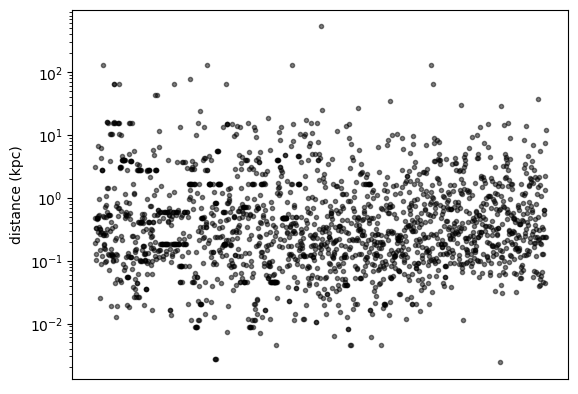

In [21]:
plt.plot(tbl.loc[tbl['distance']!='--']['distance']/1000,'k.',alpha=0.5)
plt.xticks([])
plt.ylabel('distance (kpc)')
plt.semilogy();

Right ascension and declination are given in J2000 decimal degrees.

Offsets are in arcseconds.

The `_n_match` parameters report he number of sources in the correspondin catalog that were within 12.5 arcseconds of the GALEX source position.